In [26]:
# Import necessary libraries
import matplotlib.pyplot as plt
import os
from skimage import io
import numpy as np
import pickle 
from scipy.ndimage import gaussian_filter1d
import cv2

Functions

In [27]:
# this function evaluates pixel accuract of the predicted masks
def pixel_acc(mask_dir, predict_dir):
    # Get the list of all file names in the mask directory
    file_list = os.listdir(mask_dir)

    # Initialize an empty list to store accuracy scores
    accuracy_scores = []

    # Loop through all files
    for file in file_list:
        # skip any non-PNG file
        if not file.endswith('.png'):
            continue
        # Create file paths
        mask_file = os.path.join(mask_dir, file)
        predict_file = os.path.join(predict_dir, file)

        # Load the images
        mask_img = io.imread(mask_file)
        predict_img = io.imread(predict_file)
        
        # Check max of images before normalization
        if np.max(mask_img) != 0:
            mask_img = mask_img / np.max(mask_img)
        if np.max(predict_img) != 0:
            predict_img = predict_img / np.max(predict_img)
        
        # Make sure that the mask and prediction are binary (0 and 1)
        mask_img = (mask_img > 0.5).astype(np.uint8)
        predict_img = (predict_img > 0.5).astype(np.uint8)
        
        # Calculate pixel accuracy
        correct_pixels = np.sum(mask_img == predict_img)
        total_pixels = mask_img.shape[0] * mask_img.shape[1]
        accuracy = correct_pixels / total_pixels

        # Append to accuracy scores list
        accuracy_scores.append(accuracy)

    # Create boxplot
    plt.boxplot(accuracy_scores)
    plt.title('Pixel Accuracy of UNET Predictions')
    plt.xlabel('UNET Model')
    plt.ylabel('Pixel Accuracy')
    plt.show()
    # print the mean pixel accuracy
    # print(f"Mean pixel accuracy: {np.mean(accuracy_scores)}")
    # print the median pixel accuracy
    print(f"Median pixel accuracy: {np.median(accuracy_scores)}")


# this function evaluates Dice coefficient of the predicted masks
def dice_coef(mask_dir, predict_dir):
    # Get the list of all file names in the mask directory
    file_list = os.listdir(mask_dir)

    # Initialize an empty list to store Dice scores
    dice_scores = []

    # Loop through all files
    for file in file_list:
        # Skip any non-PNG files
        if not file.endswith('.png'):
            continue

        # Create file paths
        mask_file = os.path.join(mask_dir, file)
        predict_file = os.path.join(predict_dir, file)

        dice = dice_coef_single(mask_file, predict_file)
        # Append to Dice scores list
        dice_scores.append(dice)

    # Create boxplot
    plt.boxplot(dice_scores)
    plt.title('Dice Coefficients of UNET Predictions')
    plt.xlabel('UNET Model')
    plt.ylabel('Dice Coefficient')
    plt.show()

    # get the median Dice score
    median_dice = np.median(dice_scores)
    # print the mean Dice score
    print(f"Mean Dice coefficient: {np.mean(dice_scores)}")
    # print the median Dice score
    print(f"Median Dice coefficient: {median_dice}")


# this function calculates dice coefficient of a single predicted mask and returns the dice score
def dice_coef_single(mask_file, predict_file):
    # Load the images
    mask_img = io.imread(mask_file)
    predict_img = io.imread(predict_file)
    
    # Check max of images before normalization
    if np.max(mask_img) != 0:
        mask_img = mask_img / np.max(mask_img)
    if np.max(predict_img) != 0:
        predict_img = predict_img / np.max(predict_img)
    
    # Make sure that the mask and prediction are binary (0 and 1)
    mask_img = (mask_img > 0.5).astype(np.uint8)
    predict_img = (predict_img > 0.5).astype(np.uint8)

    # if both ground truth and prediction are all zeros, then dice score is 1
    if np.sum(mask_img) == 0 and np.sum(predict_img) == 0:
        return 1.0
    
    intersection = np.sum(predict_img * mask_img)
    dice = (2. * intersection) / (np.sum(predict_img) + np.sum(mask_img) + 1e-6)

    return dice
    

# this function evaluates precision and recall of the predicted masks
def precision_recall(mask_dir, predict_dir):
    # Get the list of all file names in the mask directory
    file_list = os.listdir(mask_dir)

    # Initialize empty lists to store Precision and Recall scores
    precision_scores = []
    recall_scores = []

    # Loop through all files
    for file in file_list:
        # Skip any non-PNG files
        if not file.endswith('.png'):
            continue

        # Create file paths
        mask_file = os.path.join(mask_dir, file)
        predict_file = os.path.join(predict_dir, file)

        # Load the images
        mask_img = io.imread(mask_file)
        predict_img = io.imread(predict_file)
        
        # Check max of images before normalization
        if np.max(mask_img) != 0:
            mask_img = mask_img / np.max(mask_img)
        if np.max(predict_img) != 0:
            predict_img = predict_img / np.max(predict_img)
        
        # Make sure that the mask and prediction are binary (0 and 1)
        mask_img = (mask_img > 0.5).astype(np.uint8)
        predict_img = (predict_img > 0.5).astype(np.uint8)
        
        # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
        TP = np.sum((predict_img == 1) & (mask_img == 1))
        FP = np.sum((predict_img == 1) & (mask_img == 0))
        FN = np.sum((predict_img == 0) & (mask_img == 1))
        
        # Calculate Precision and Recall scores and append to respective lists
        if (TP + FP) > 0:
            precision = TP / (TP + FP)
            precision_scores.append(precision)
        
        if (TP + FN) > 0:
            recall = TP / (TP + FN)
            recall_scores.append(recall)

    # Create boxplot for Precision scores
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.boxplot(precision_scores)
    plt.title('Precision of UNET Predictions')
    plt.xlabel('UNET Model')
    plt.ylabel('Precision')

    # Create boxplot for Recall scores
    plt.subplot(1,2,2)
    plt.boxplot(recall_scores)
    plt.title('Recall of UNET Predictions')
    plt.xlabel('UNET Model')
    plt.ylabel('Recall')

    plt.tight_layout()
    plt.show()  
    # print the mean Precision 
    #print(f"Mean Precision: {np.mean(precision_scores)}")
    # print the median Precision
    print(f"Median Precision: {np.median(precision_scores)}")
    # print the mean Recall
    #print(f"Mean Recall: {np.mean(recall_scores)}")
    # print the median Recall
    print(f"Median Recall: {np.median(recall_scores)}")
    # print the dice scores array


def postprocess_masks(input_folder, output_folder):
    # Create the output folder if not exists
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    # Iterate through the files in the input directory
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            filepath = os.path.join(input_folder, filename)
                
            # Read the mask image in grayscale
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

            # Apply a median filter to reduce noise
            median_image = cv2.medianBlur(image, 5)

            # Threshold the image
            _, thresh_image = cv2.threshold(median_image, 127, 255, cv2.THRESH_BINARY)

            # Find the contours
            contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Find the largest contour and approximate it
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                epsilon = 0.02 * cv2.arcLength(largest_contour, True)
                approx_contour = cv2.approxPolyDP(largest_contour, epsilon, True)

                # Create a blank mask and draw the filled, approximated contour
                final_mask = np.zeros_like(image)
                cv2.drawContours(final_mask, [approx_contour], -1, 255, thickness=cv2.FILLED)

                # Save the processed image
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, final_mask)

                print(f'Processed {filename}')

    print('Postprocessing completed.')


def postprocess_masks(input_folder, output_folder):
    # Create the output folder if not exists
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    # Iterate through the files in the input directory
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            filepath = os.path.join(input_folder, filename)

            # Read the mask image in grayscale
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

            # Apply a median filter to reduce noise
            median_image = cv2.medianBlur(image, 5)

            # Threshold the image
            _, thresh_image = cv2.threshold(median_image, 127, 255, cv2.THRESH_BINARY)

            # Find contours
            contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Find the largest contour
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)

                # Smooth the contour using Gaussian filtering
                smooth_contour = gaussian_filter1d(largest_contour.squeeze(), sigma=5, axis=0)
                smooth_contour = smooth_contour.reshape(-1, 1, 2).astype(np.int32)

                # Create a blank mask and draw the filled, smoothed contour
                final_mask = np.zeros_like(image)
                cv2.drawContours(final_mask, [smooth_contour], -1, 255, thickness=cv2.FILLED)

                # Save the processed image
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, final_mask)
            # if no contours found, save the original image
            else:
                cv2.imwrite(os.path.join(output_folder, filename), image)

    print('Postprocessing completed.')



# plot predictions with ground truth and images
def plot_predictions(img_dir, mask_dir, predict_dir, n):
    # plot the first 10 img with ground truth mask and predicted mask
    for i in range(n): 
        # define file paths
        img_file = os.path.join(img_dir, os.listdir(img_dir)[i])
        mask_file = os.path.join(mask_dir, os.listdir(mask_dir)[i])
        predict_file = os.path.join(predict_dir, os.listdir(predict_dir)[i])
        
        # load the images
        img = io.imread(img_file, as_gray=True)
        mask = io.imread(mask_file, as_gray=True)
        predict = io.imread(predict_file, as_gray=True)
        
        # plot the images
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.imshow(img, cmap='gray')
        plt.title('Image')
        plt.subplot(1,3,2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.subplot(1,3,3)
        plt.imshow(predict, cmap='gray')
        plt.title('Predicted Mask')
        plt.tight_layout()
        plt.show()
        # print the dice score of this prediction
        print(f"Dice score: {dice_coef_single(mask_file, predict_file)}")

# plot the loss and accuracy curves
def plot_curves(history_dir):
    with open(history_dir, 'rb') as file:
        loaded_history = pickle.load(file)

    # Access training loss, test loss, and dice score
    train_loss = loaded_history["train_loss"]
    test_loss = loaded_history["test_loss"]
    test_dice = loaded_history["test_dice"]

    test_dice = [t.cpu().numpy() for t in test_dice]

    # Plot the training and test loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(train_loss, label="Train Loss", color='blue')
    plt.plot(test_loss, label="Test Loss", color='red')
    plt.title("Training and Test Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(test_dice, label="Test Dice Score", color='green')
    plt.title("Test Dice Score")
    plt.xlabel("Epoch #")
    plt.ylabel("Dice Score")
    plt.legend()

    # Show the plots
    plt.tight_layout()  # Adjust layout for better visualization
    plt.show()

### MR

In [28]:
# Define the directories
img_dir = 'dataset_mr/test/images'
mask_dir = 'dataset_mr/test/mask'
post_predict_dir = 'dataset_mr/test/predict_unet_postprocess'
predict_dir = 'dataset_mr/test/predict_unet'
training_history_dir = 'dataset_mr/model_unet/history.pkl'

Post-Processing

In [29]:
postprocess_masks(predict_dir, post_predict_dir)

Postprocessing completed.


Evaluation (with post-processing)

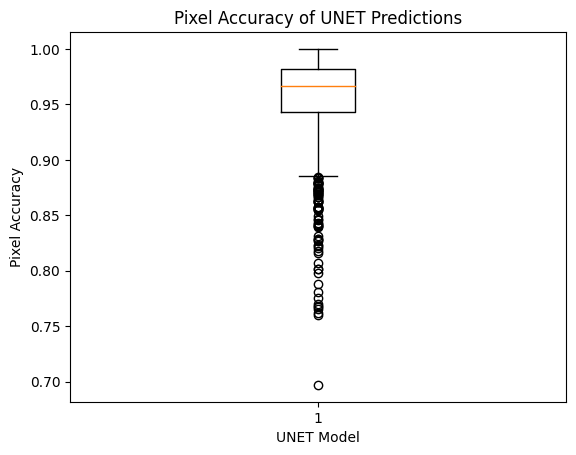

Median pixel accuracy: 0.9661102294921875


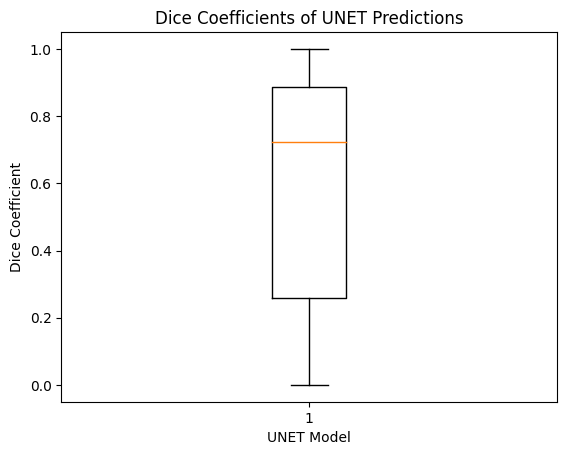

Mean Dice coefficient: 0.5788131898014302
Median Dice coefficient: 0.7224576270490699


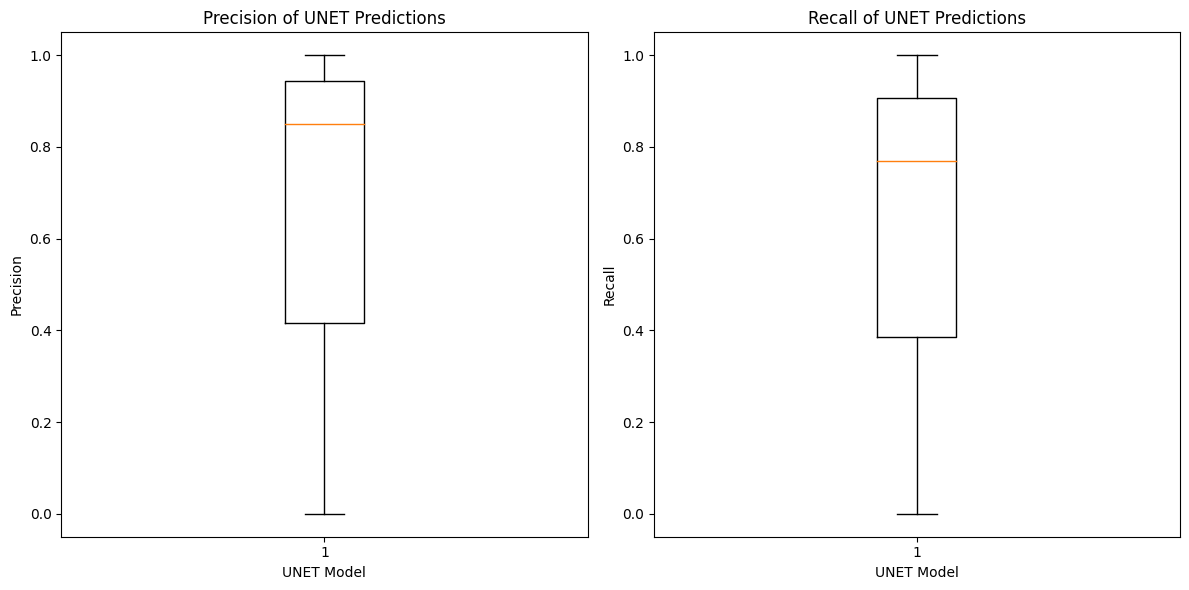

Median Precision: 0.8495195256593744
Median Recall: 0.7701394998114868


In [30]:
pixel_acc(mask_dir, post_predict_dir)
dice_coef(mask_dir, post_predict_dir)
precision_recall(mask_dir, post_predict_dir)

Evaluate the training history

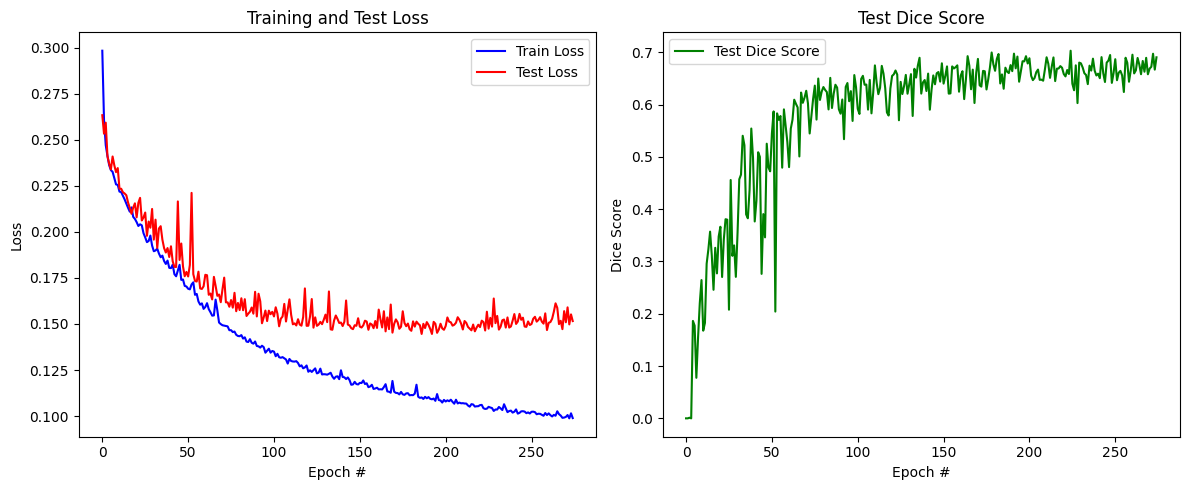

In [32]:
plot_curves(training_history_dir)

Show the first 10 images with predicted mask (with post-processing) along with ground truth

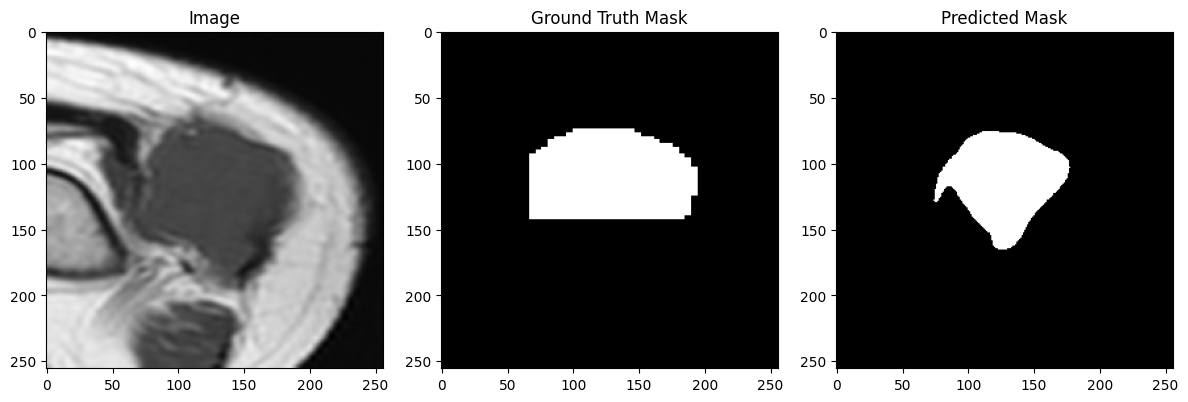

Dice score: 0.7379622640952481


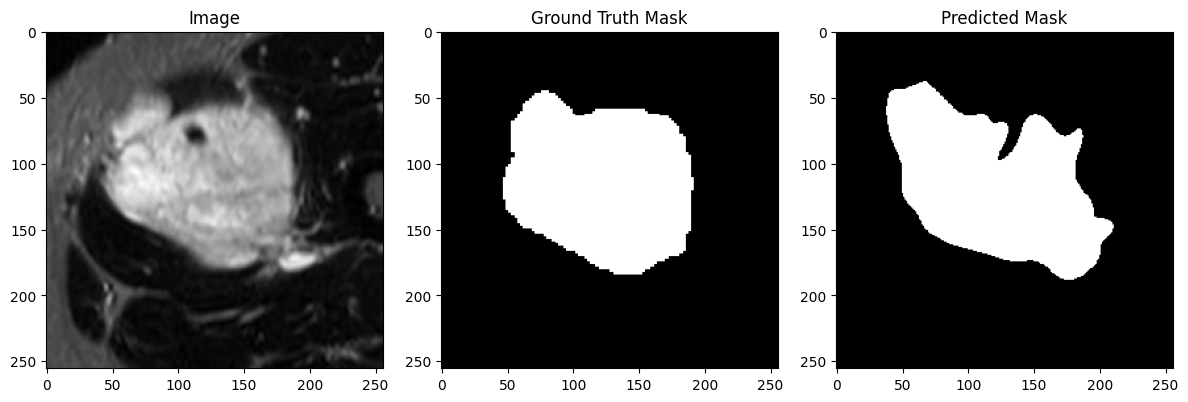

Dice score: 0.8669860226764556


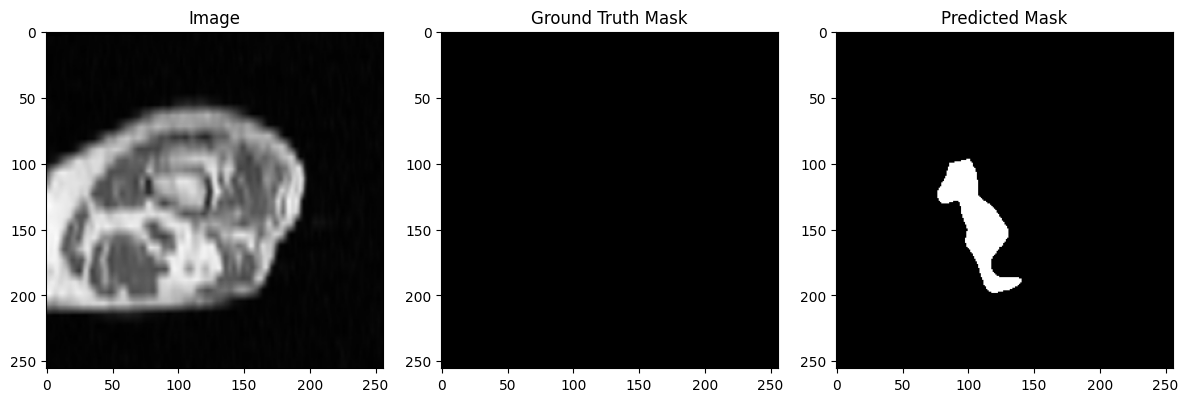

Dice score: 0.0


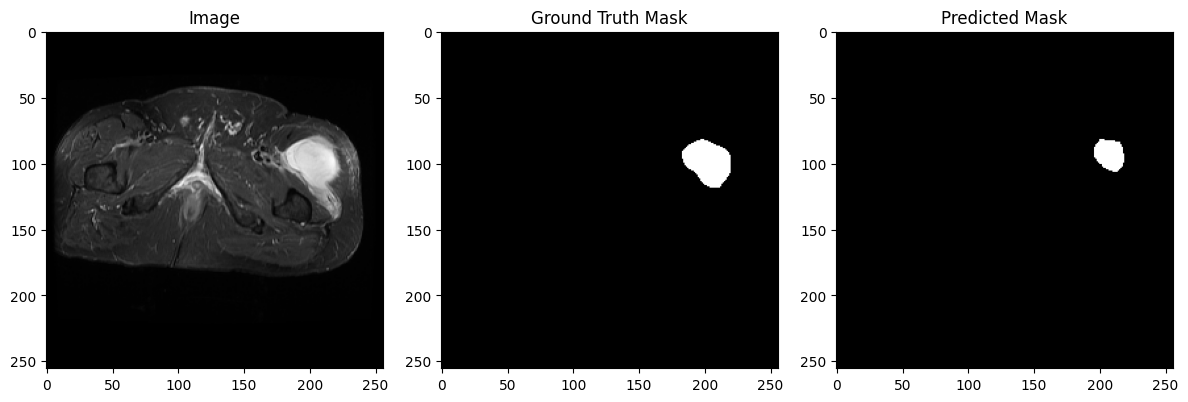

Dice score: 0.5554760196453286


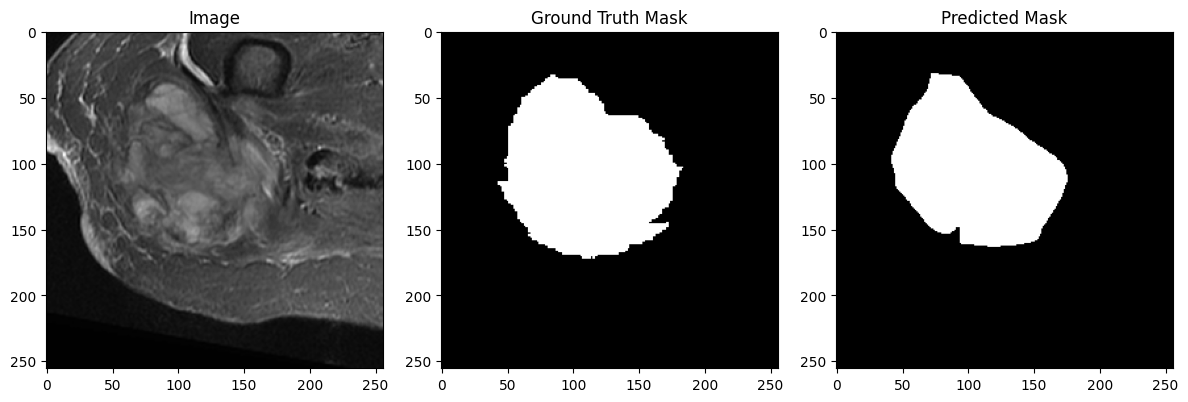

Dice score: 0.8984143719981177


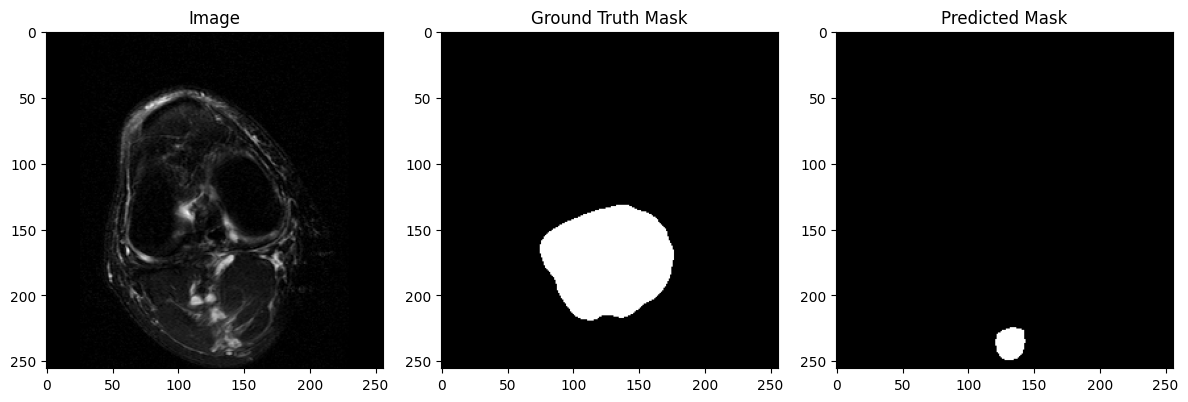

Dice score: 0.0


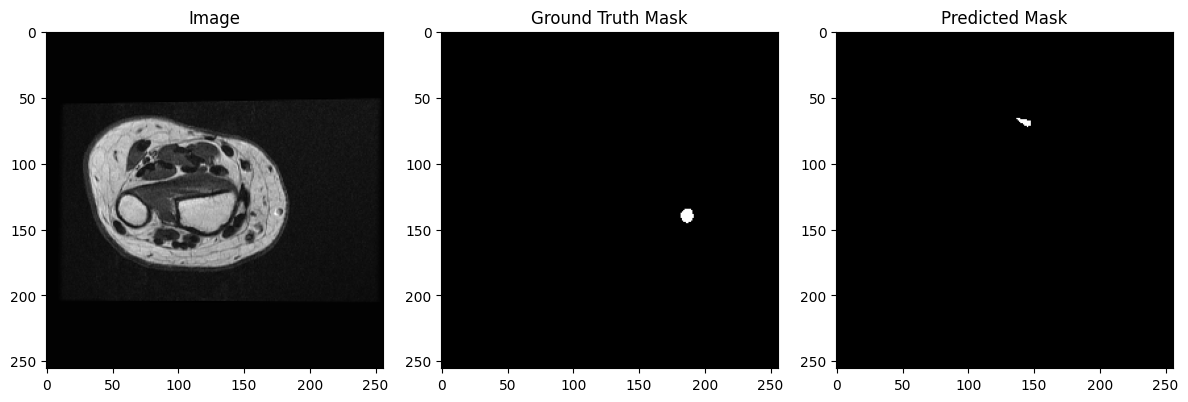

Dice score: 0.0


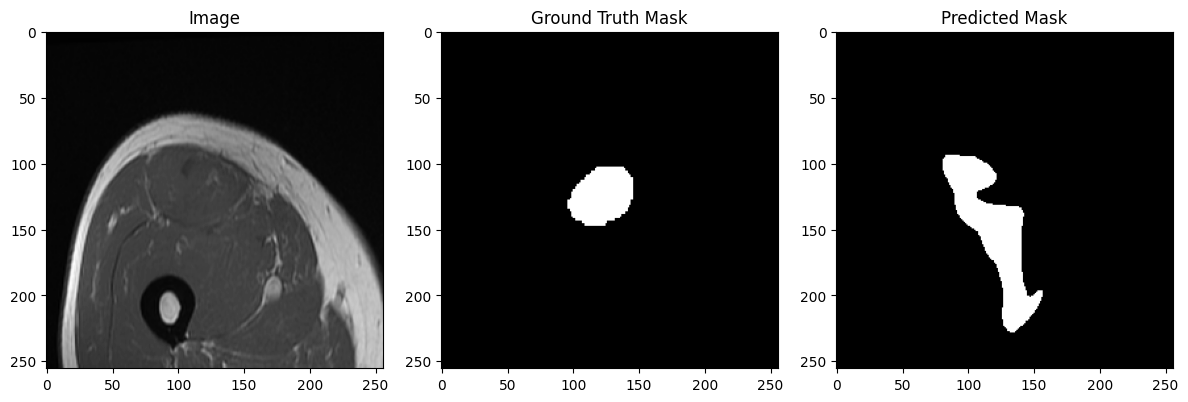

Dice score: 0.31176470582504323


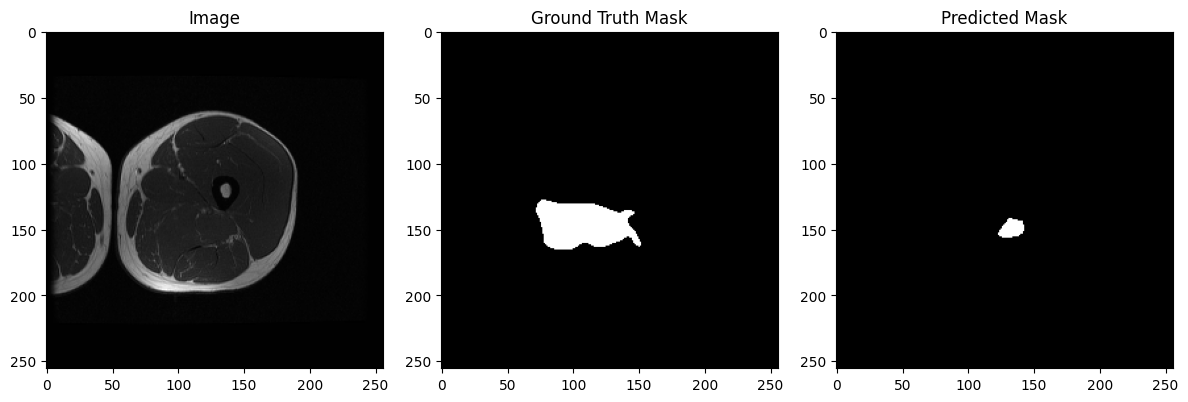

Dice score: 0.18127911894058488


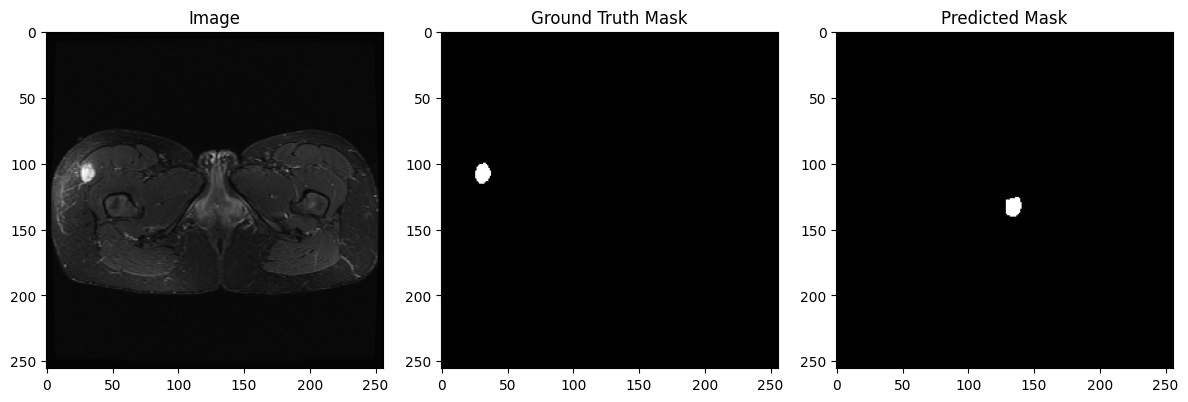

Dice score: 0.0


In [33]:
plot_predictions(img_dir, mask_dir, post_predict_dir, 10)

### PT

In [132]:
# Define the directories
img_dir = 'dataset_pt/test/images'
mask_dir = 'dataset_pt/test/mask'
post_predict_dir = 'dataset_pt/test/predict_unet_postprocess'
predict_dir = 'dataset_pt/test/predict_unet'
training_history_dir = 'dataset_pt/model_unet/history.pkl'

Post-Processing

In [134]:
postprocess_masks(predict_dir, post_predict_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_pt/test/predict_unet'

Evaluation (with post-processing)

In [133]:
pixel_acc(mask_dir, post_predict_dir)
dice_coef(mask_dir, post_predict_dir)
precision_recall(mask_dir, post_predict_dir)

FileNotFoundError: No such file: '/Users/adrian/Desktop/cs-projects.nosync/multimodal-imaging/dataset_pt/test/predict_unet_postprocess/1.3.6.1.4.1.14519.5.2.1.5168.1900.232998923050211076724231654195_103.png'

Evaluate the training history

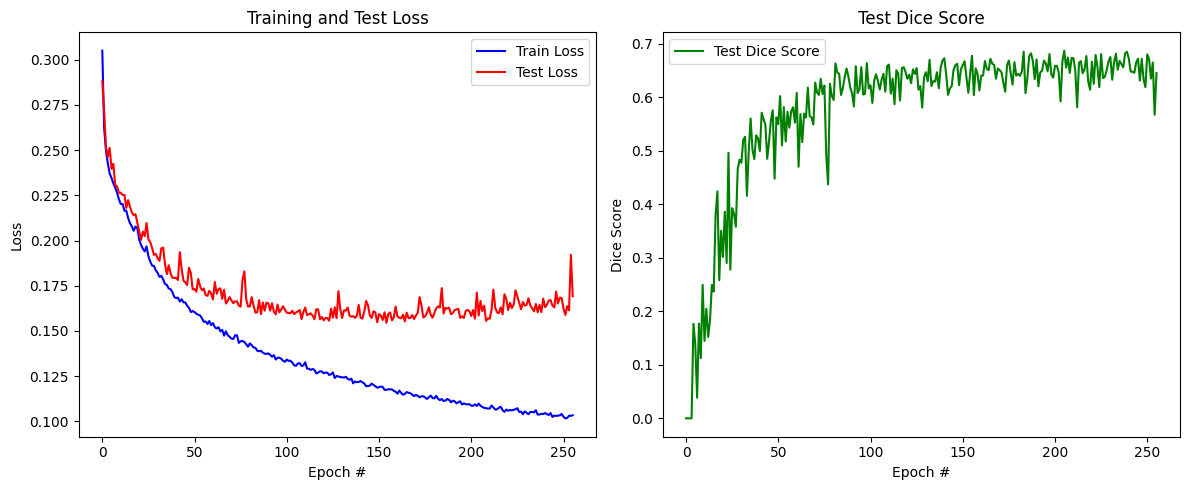

In [103]:
plot_curves(training_history_dir)

Show the first 10 images with predicted mask (with post-processing) along with ground truth

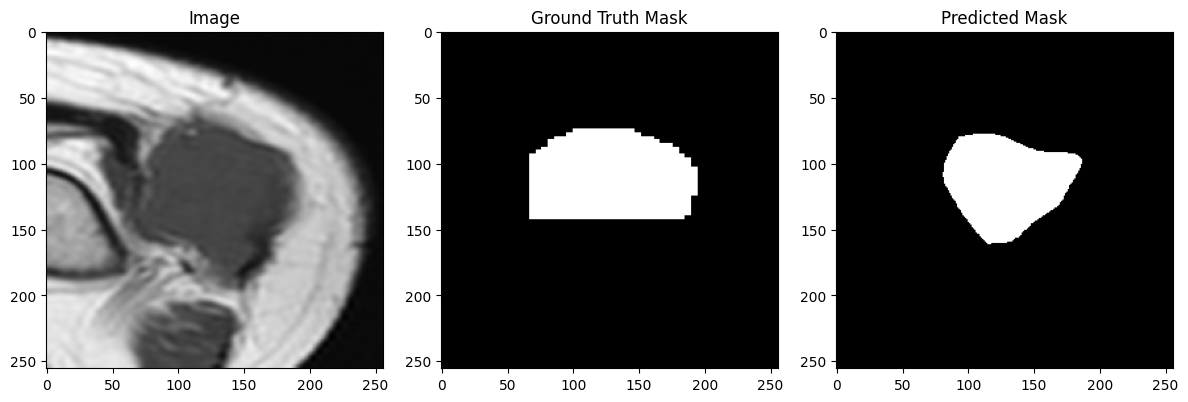

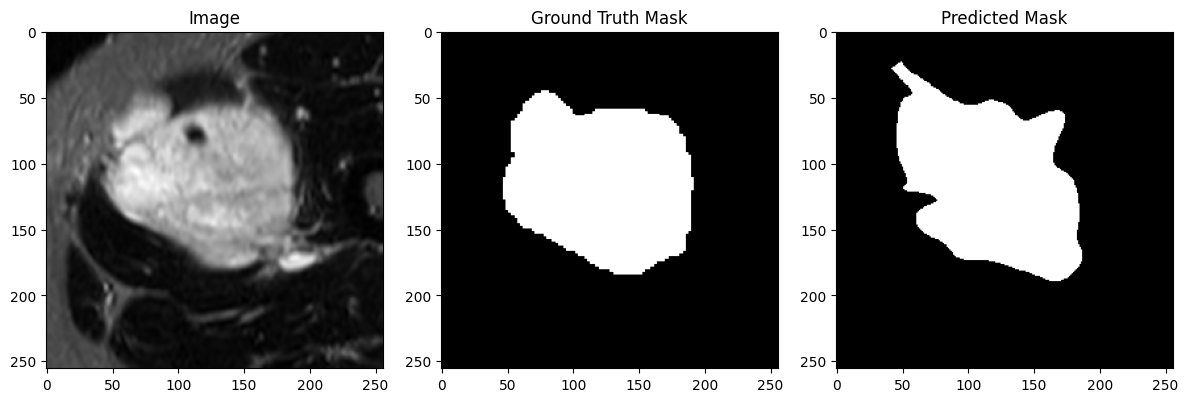

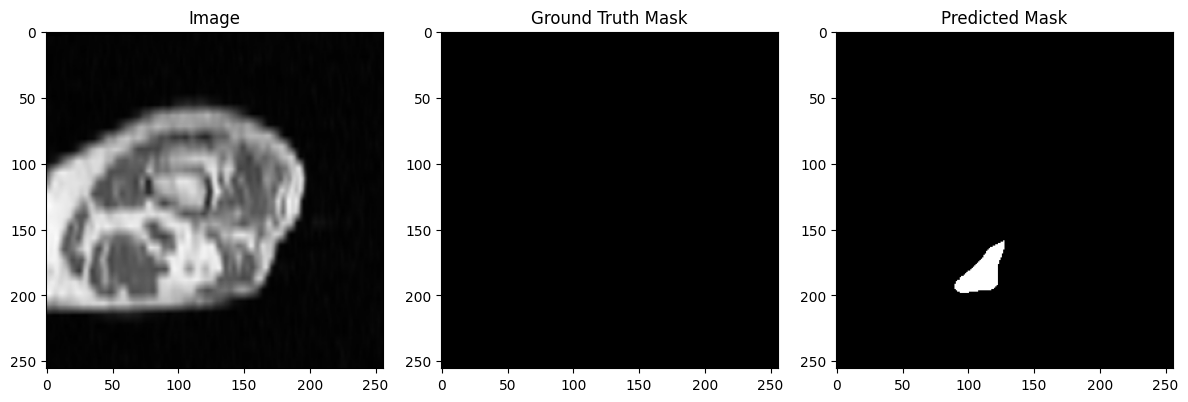

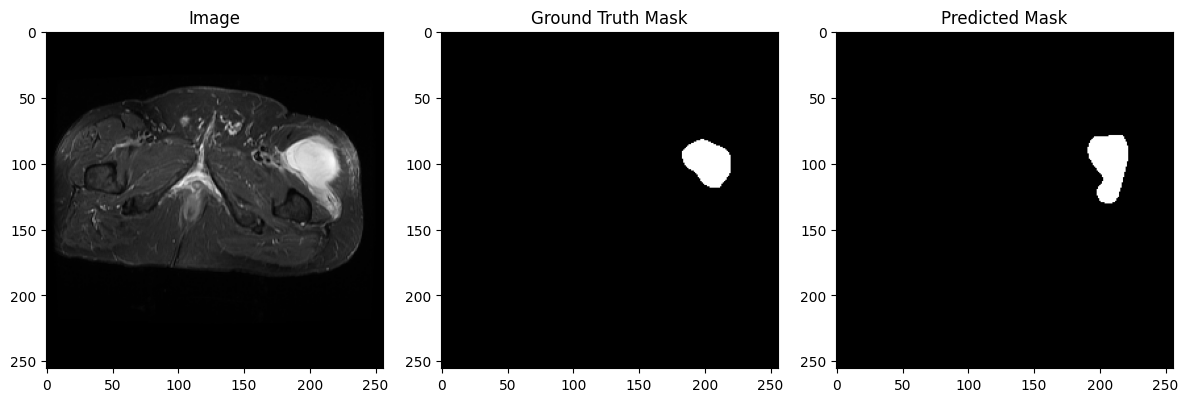

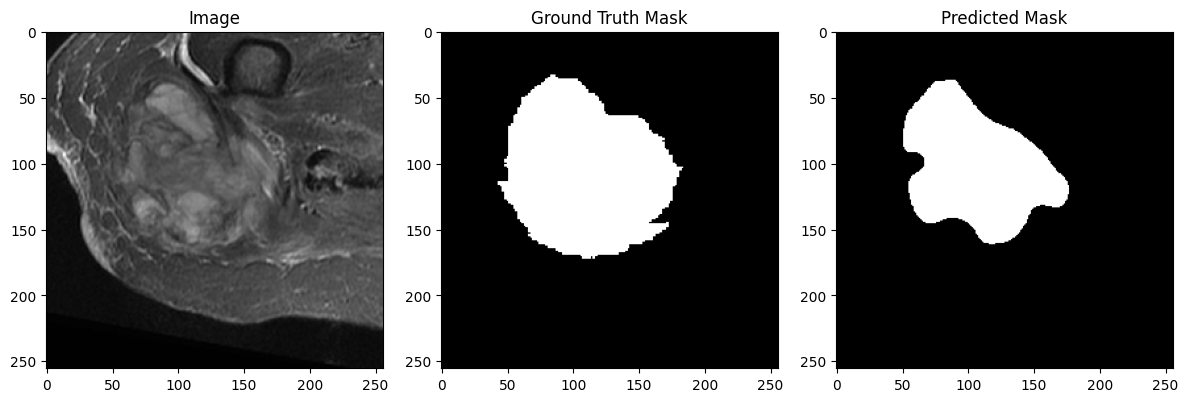

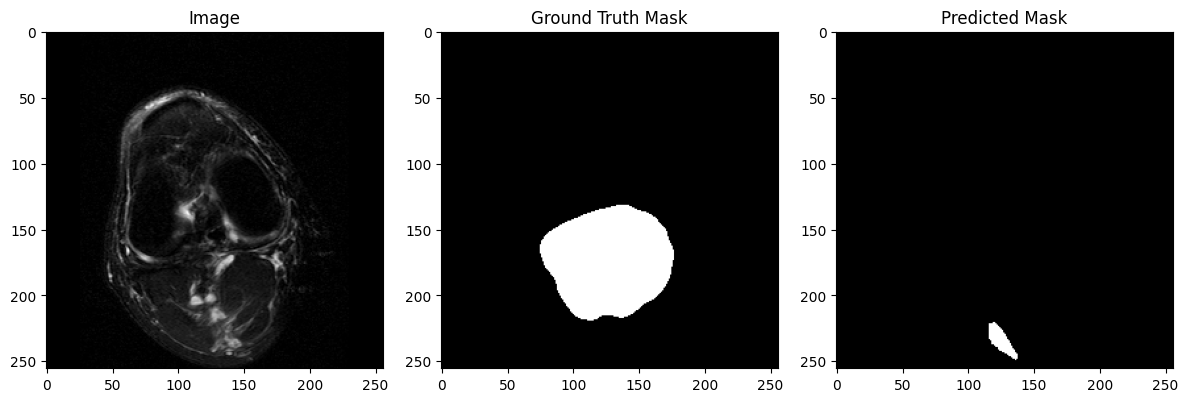

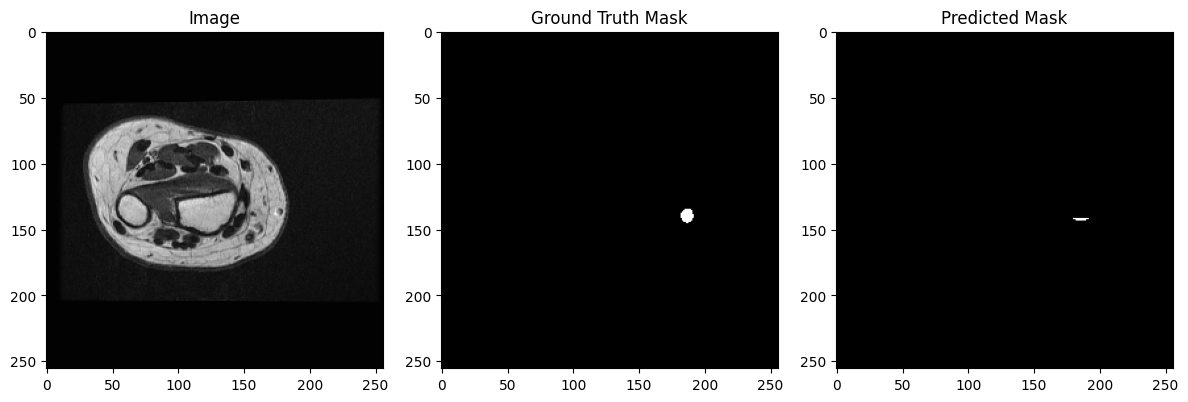

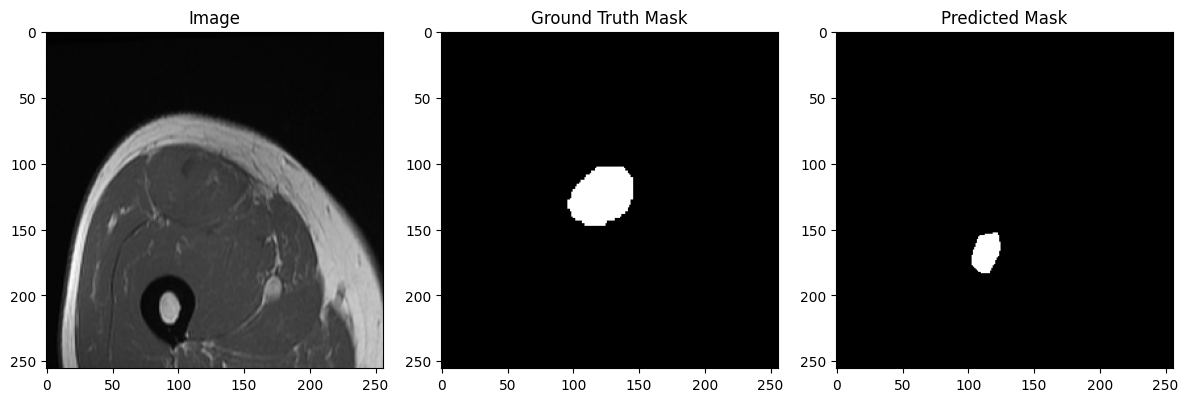

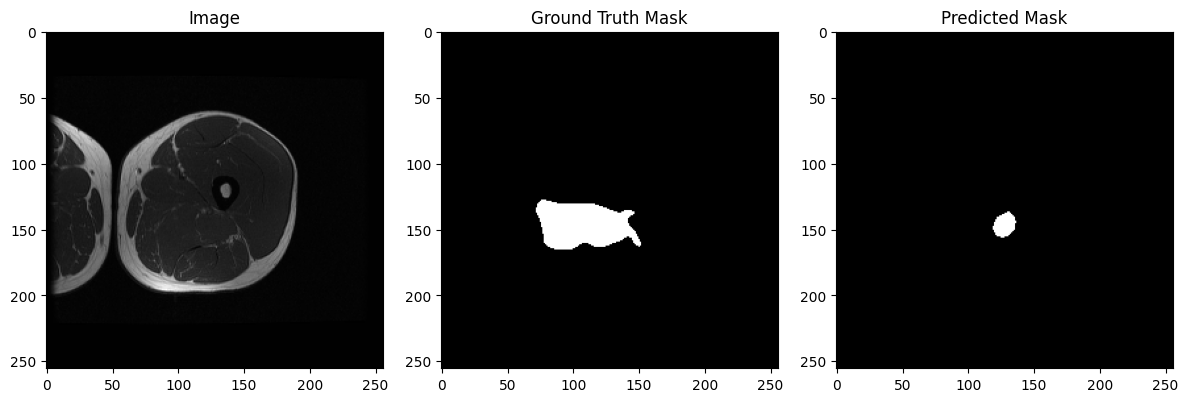

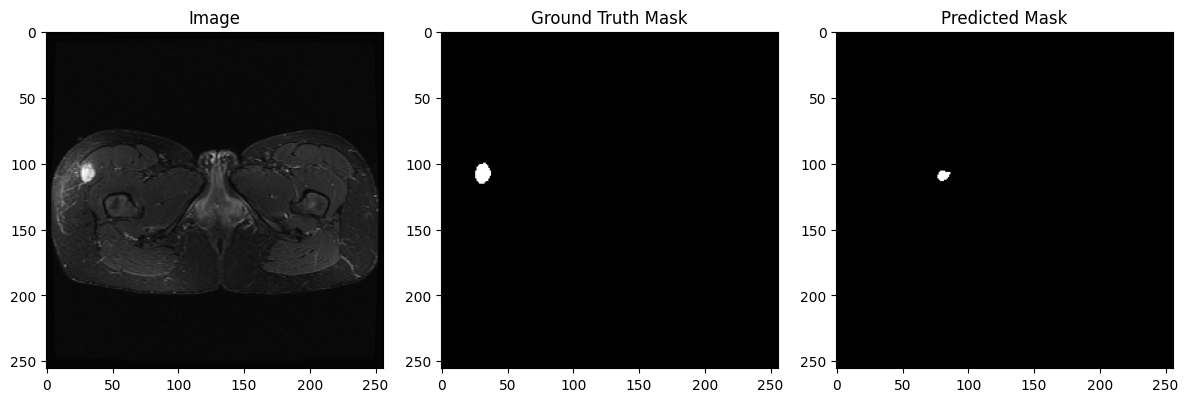

In [104]:
plot_predictions(img_dir, mask_dir, post_predict_dir, 10)

### CT

In [18]:
# Define the directories
img_dir = 'dataset_ct/test/images'
mask_dir = 'dataset_ct/test/mask'
post_predict_dir = 'dataset_ct/test/predict_unet_postprocess'
predict_dir = 'dataset_ct/test/predict_unet'
training_history_dir = 'dataset_ct/model_unet/history.pkl'

Post-Processing

In [123]:
postprocess_masks(predict_dir, post_predict_dir)

Postprocessing completed.


Evaluation (with post-processing)

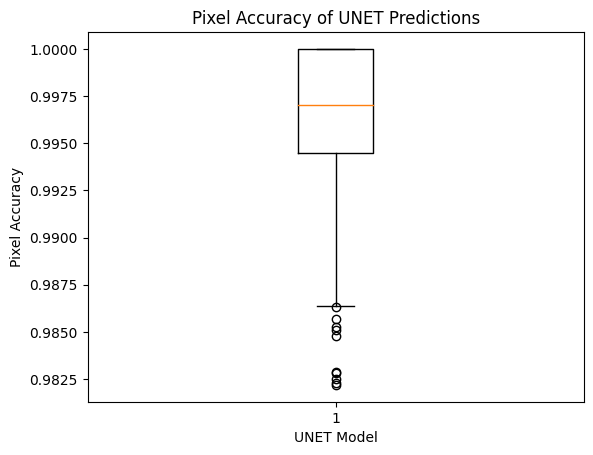

Median pixel accuracy: 0.9970245361328125


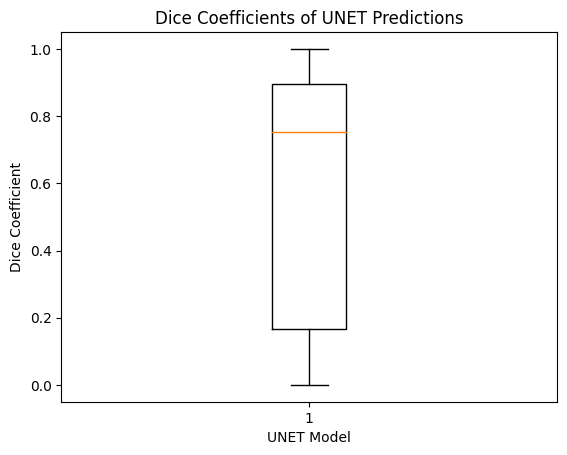

Mean Dice coefficient: 0.5834714763031489
Median Dice coefficient: 0.7535011124060474


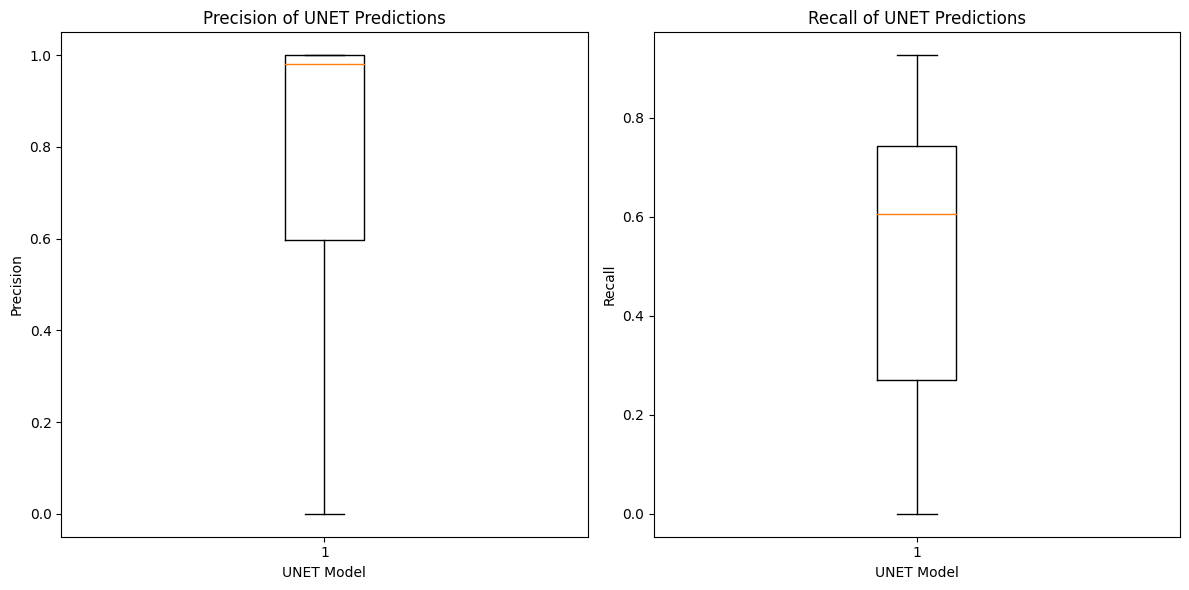

Median Precision: 0.9807692307692307
Median Recall: 0.6048484088394948


In [19]:
pixel_acc(mask_dir, post_predict_dir)
dice_coef(mask_dir, post_predict_dir)
precision_recall(mask_dir, post_predict_dir)

Evaluate the training history

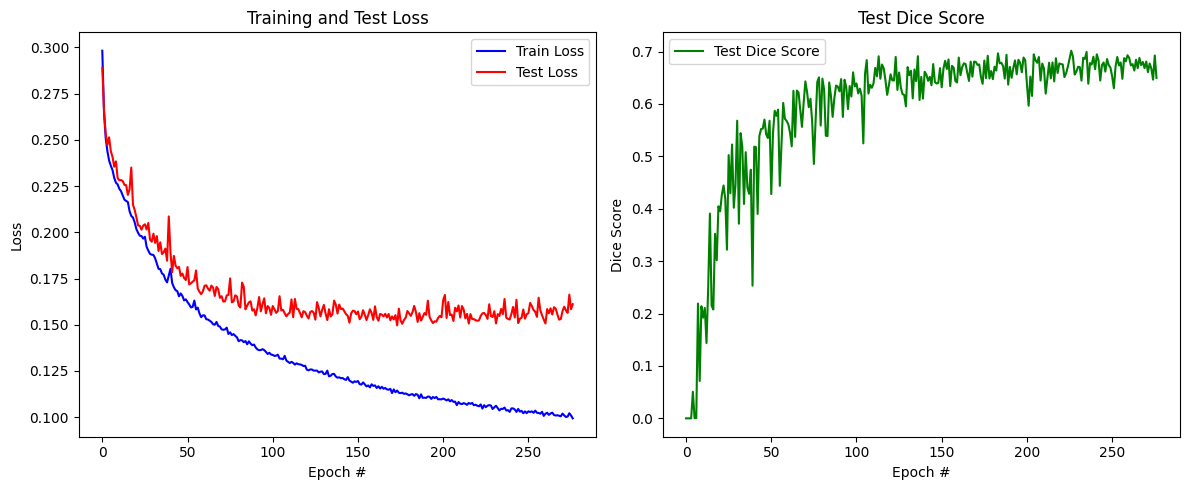

In [111]:
plot_curves(training_history_dir)

Show the first 10 images with predicted mask (with post-processing) along with ground truth

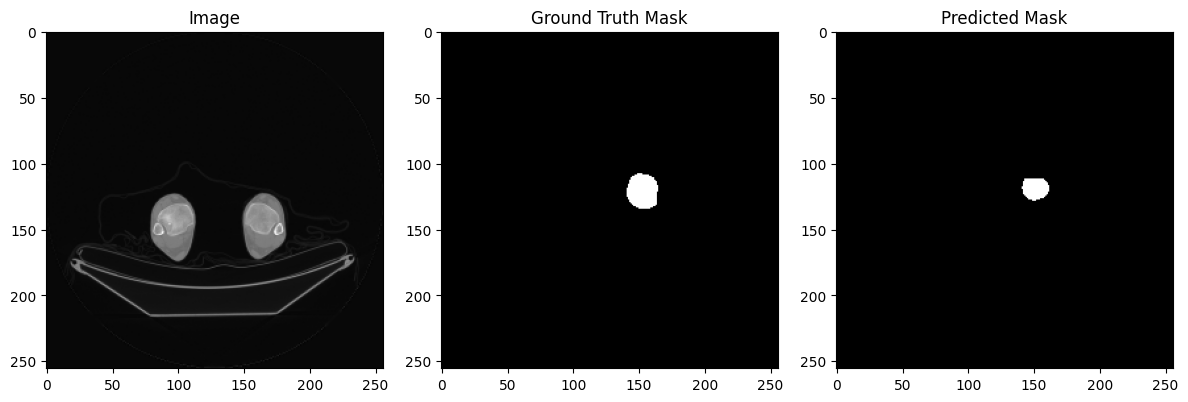

Dice score: 0.693069306072934


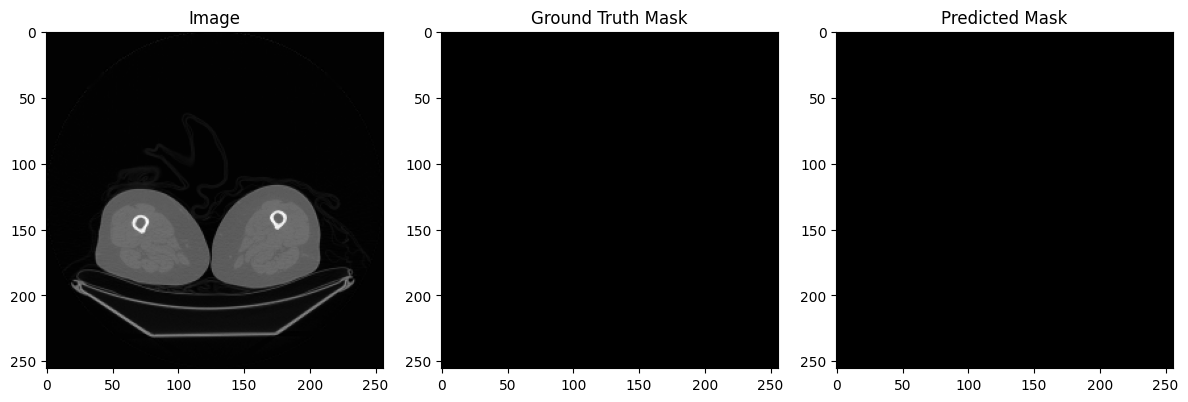

Dice score: 1.0


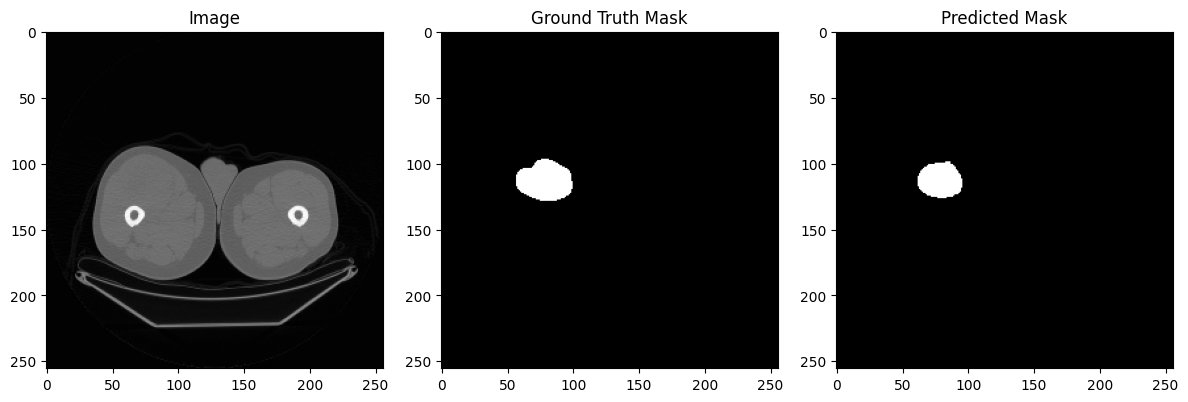

Dice score: 0.8301675973015823


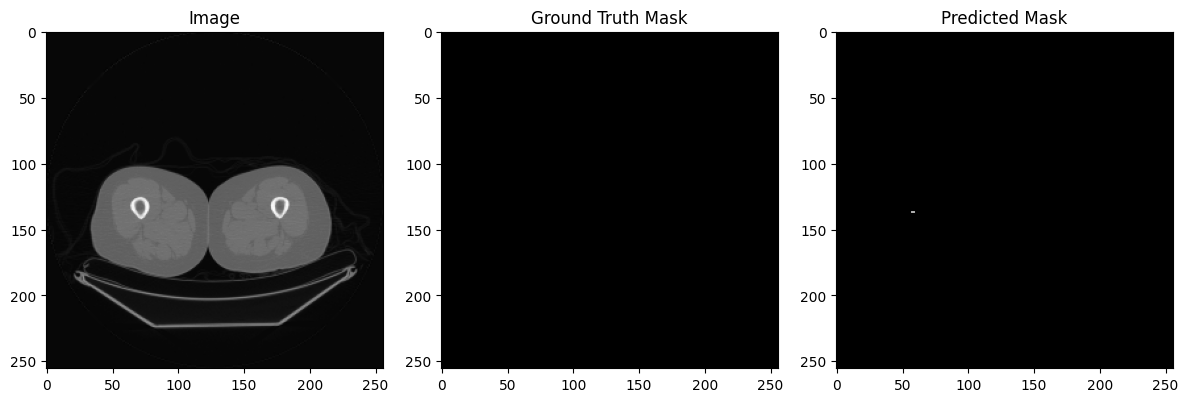

Dice score: 0.0


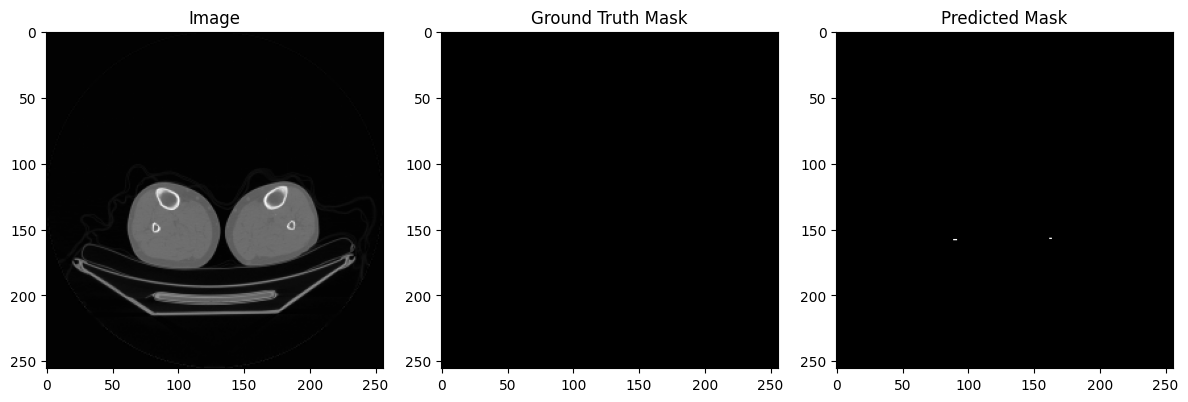

Dice score: 0.0


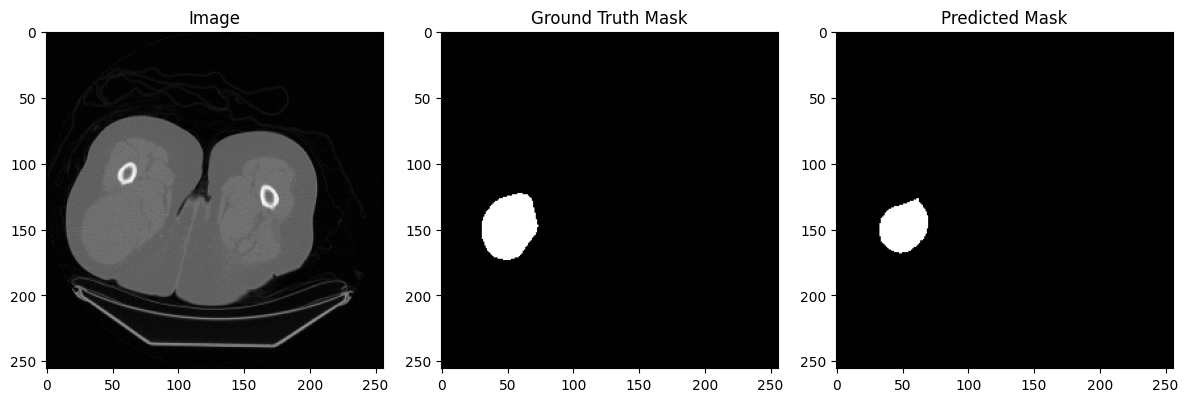

Dice score: 0.8140122785070378


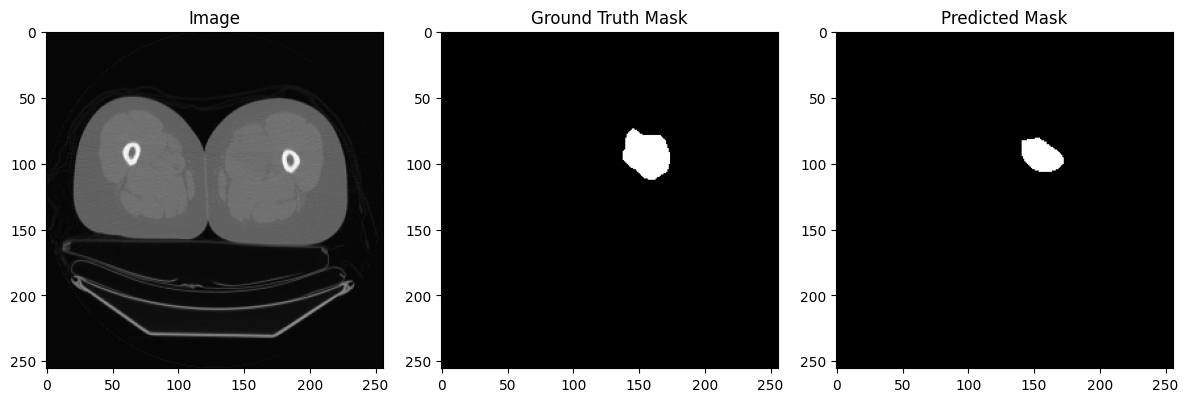

Dice score: 0.7509339970417596


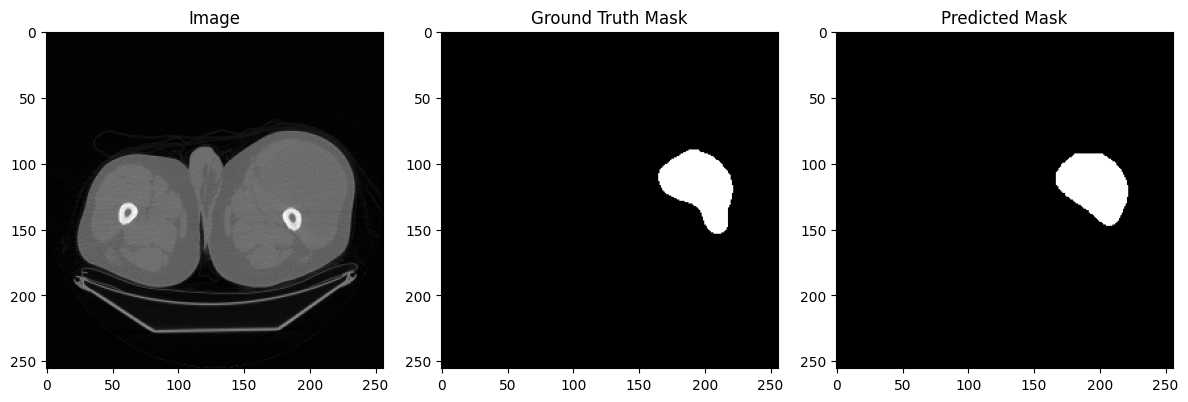

Dice score: 0.9339227545523678


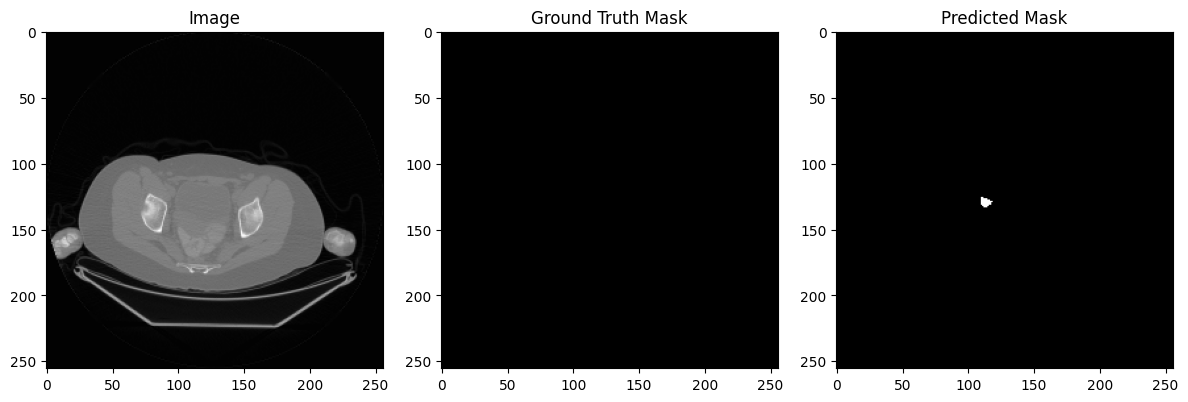

Dice score: 0.0


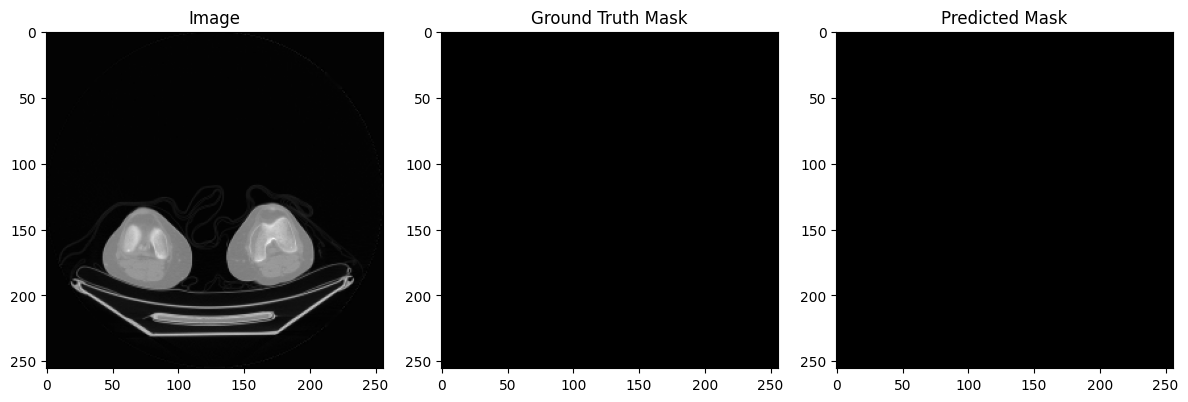

Dice score: 1.0


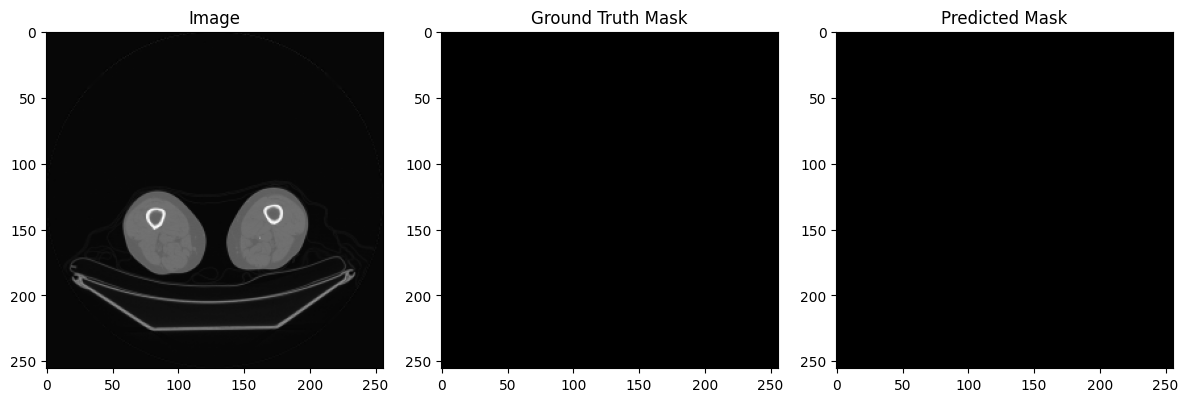

Dice score: 1.0


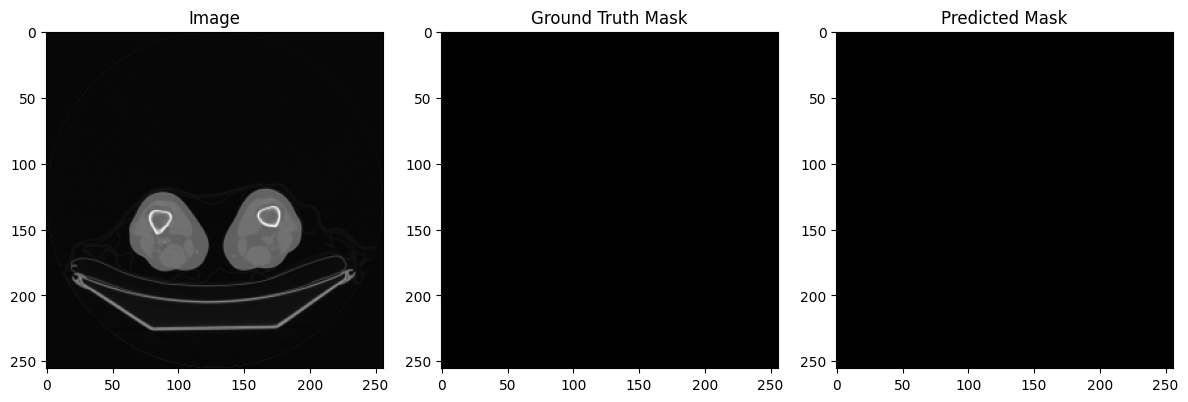

Dice score: 1.0


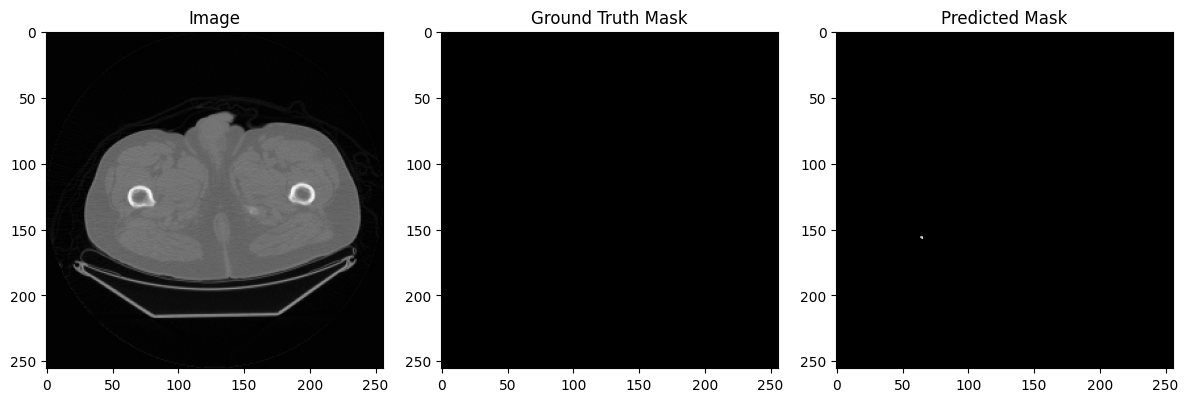

Dice score: 0.0


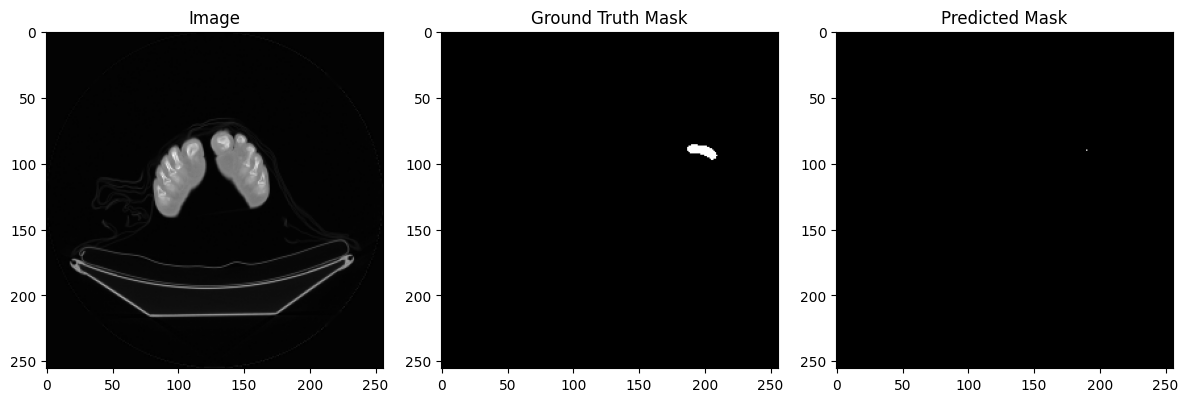

Dice score: 0.01315789465027701


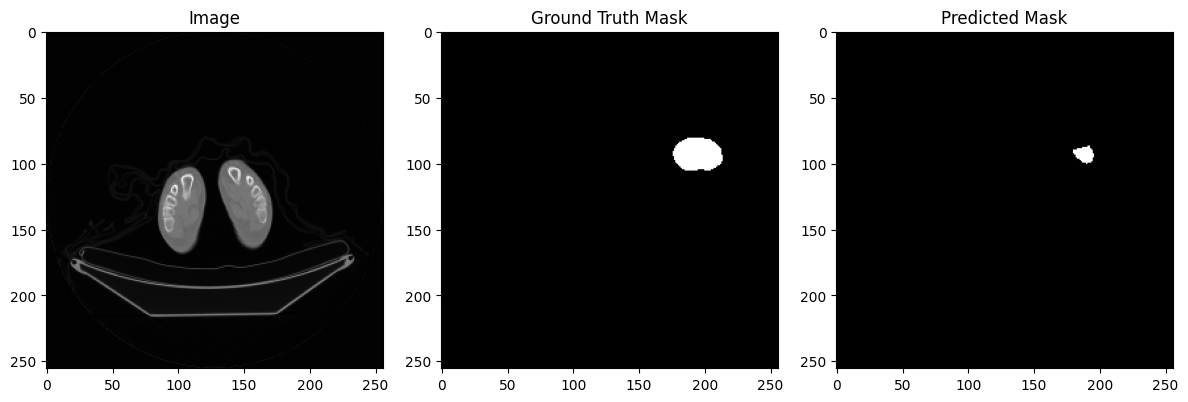

Dice score: 0.31739130400283555


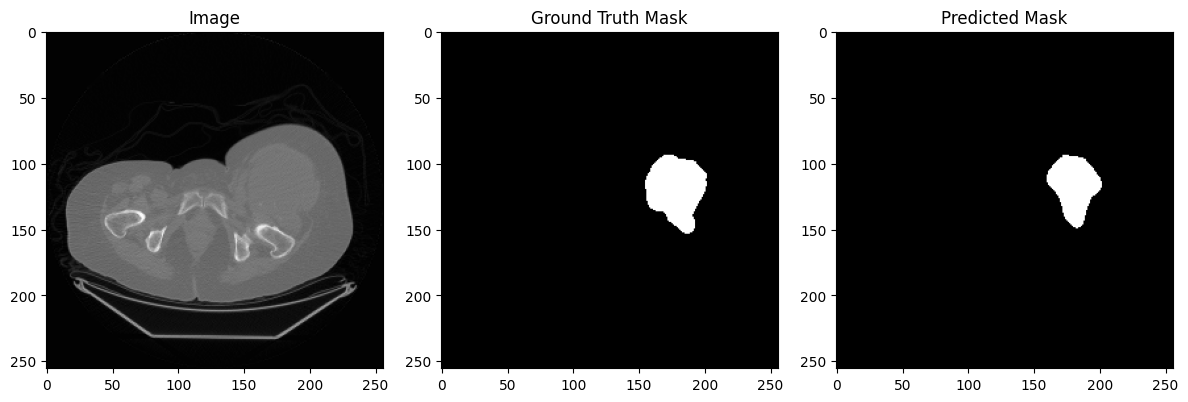

Dice score: 0.8391734049598163


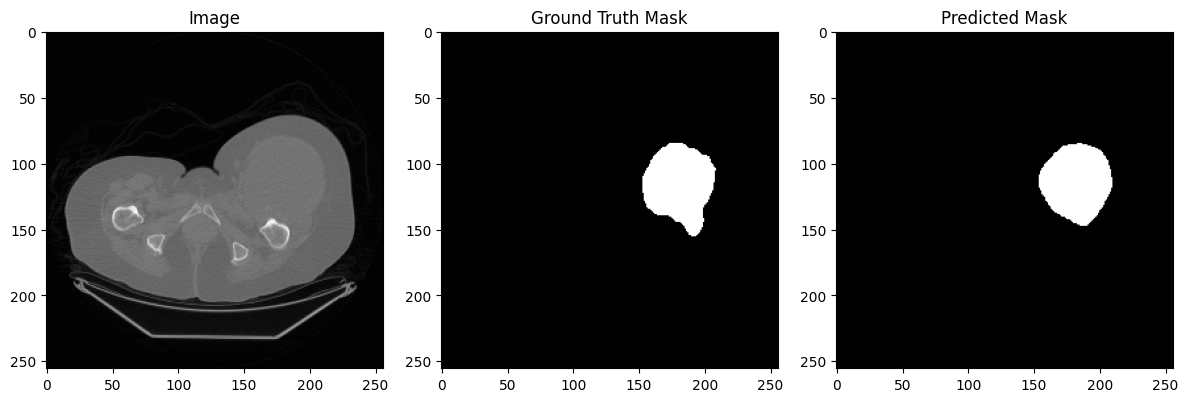

Dice score: 0.9224644548014285


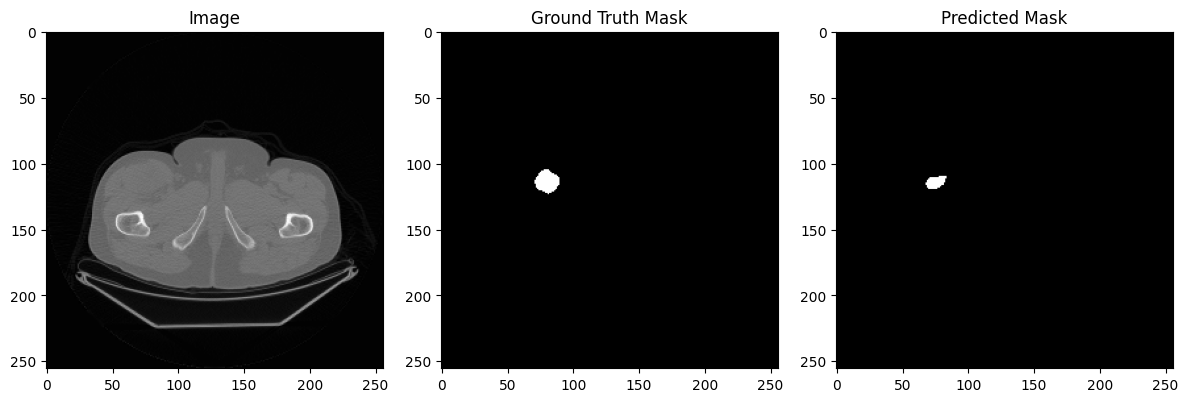

Dice score: 0.5095890396997561


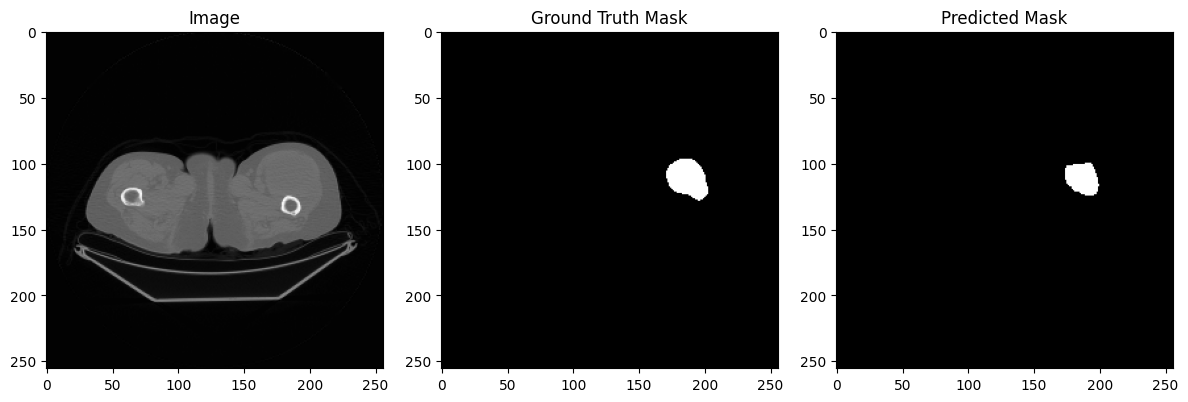

Dice score: 0.8149350642735916


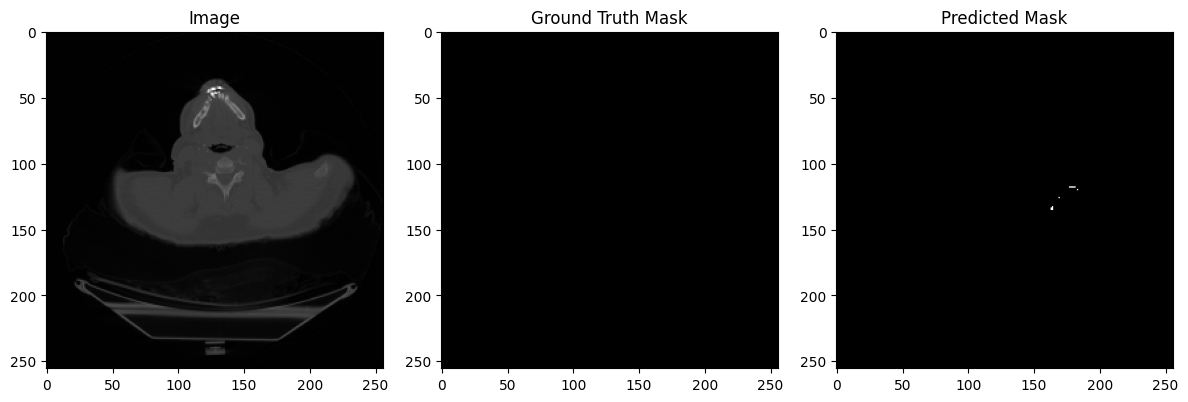

Dice score: 0.0


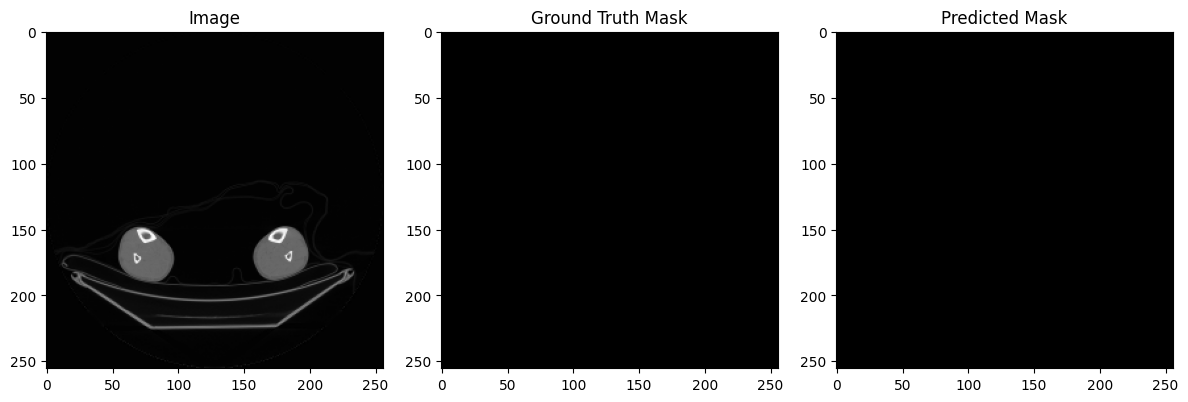

Dice score: 1.0


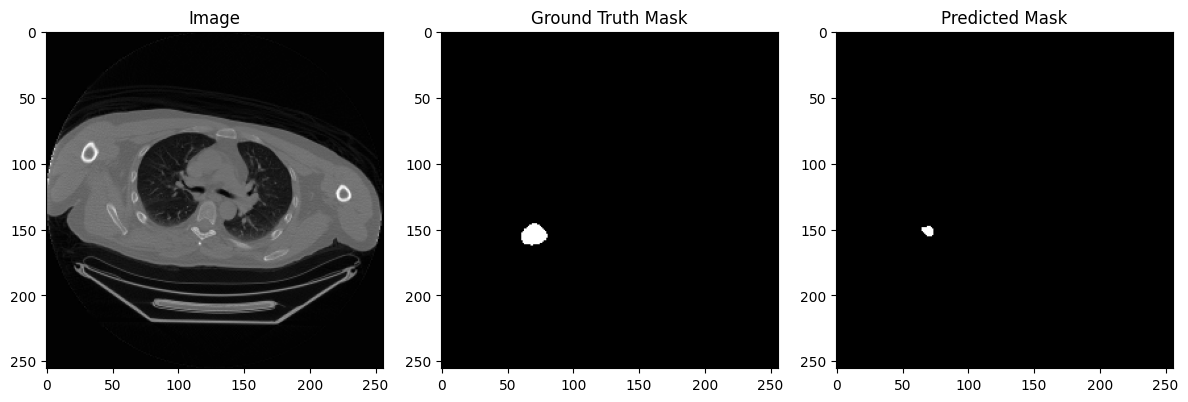

Dice score: 0.36120401216988623


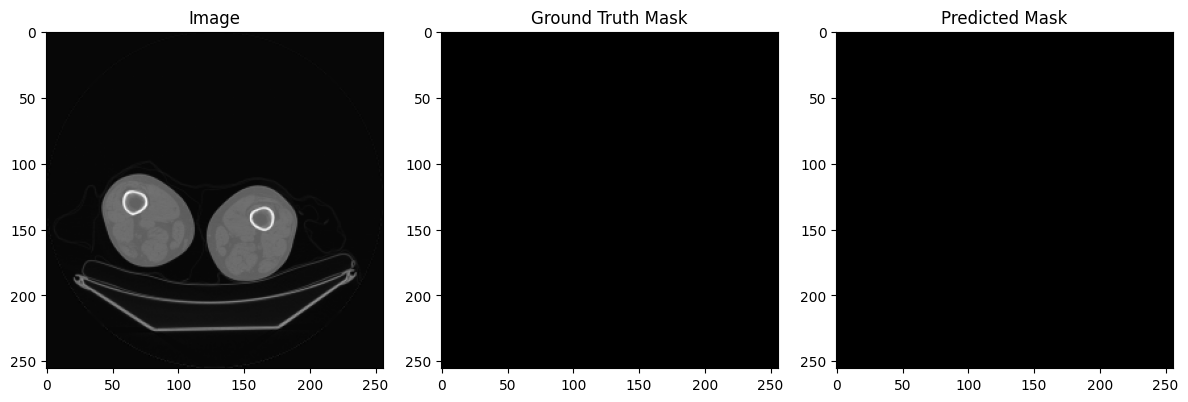

Dice score: 1.0


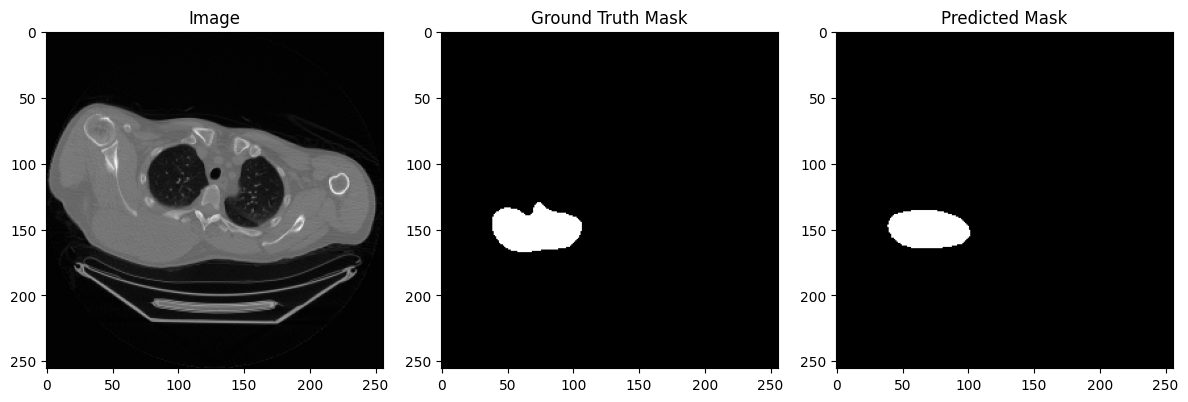

Dice score: 0.8683189009052497


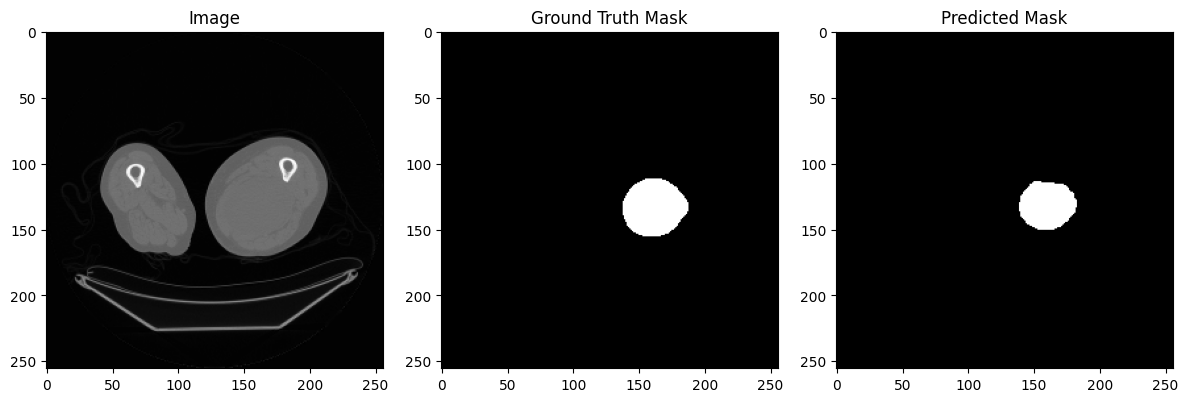

Dice score: 0.8569505214214236


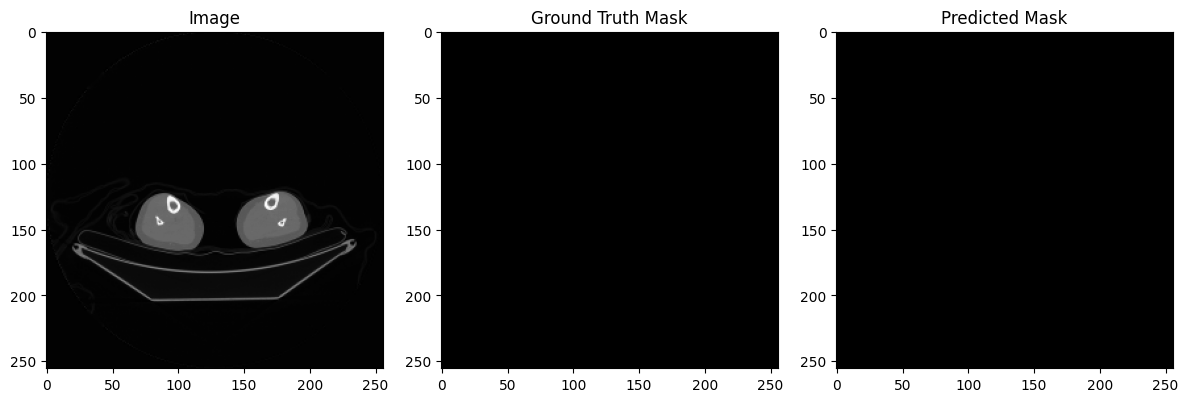

Dice score: 1.0


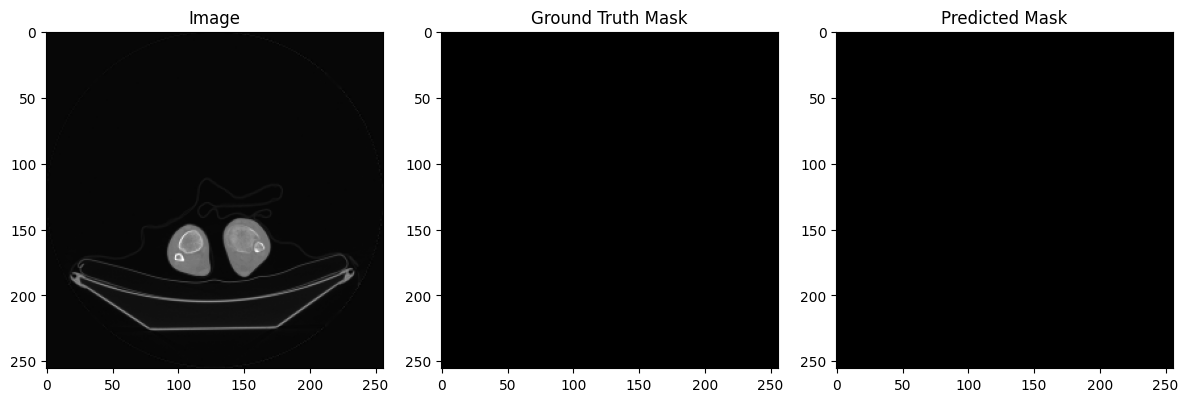

Dice score: 1.0


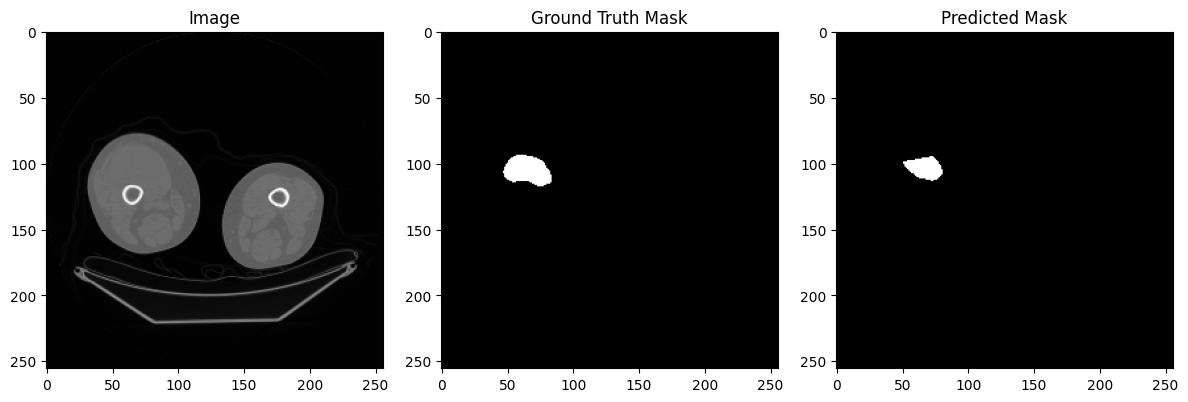

Dice score: 0.7299703256874676


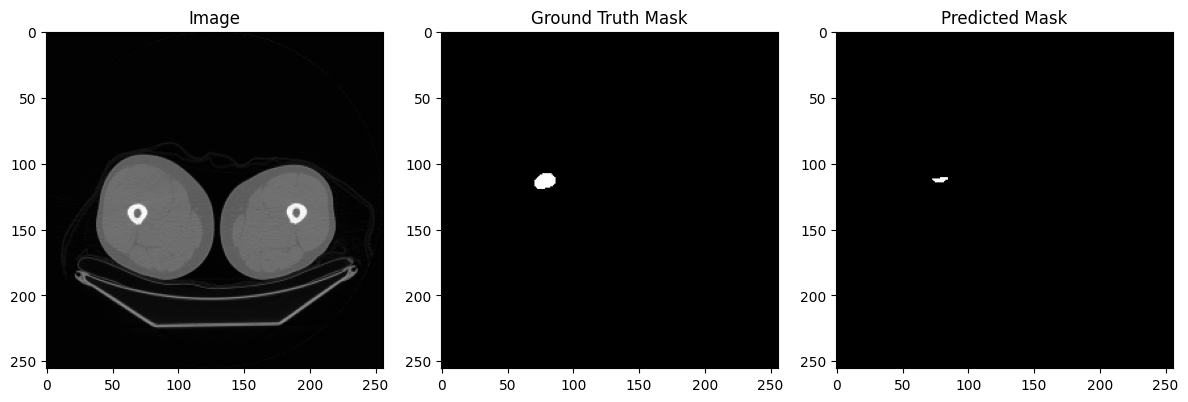

Dice score: 0.36559139588391726


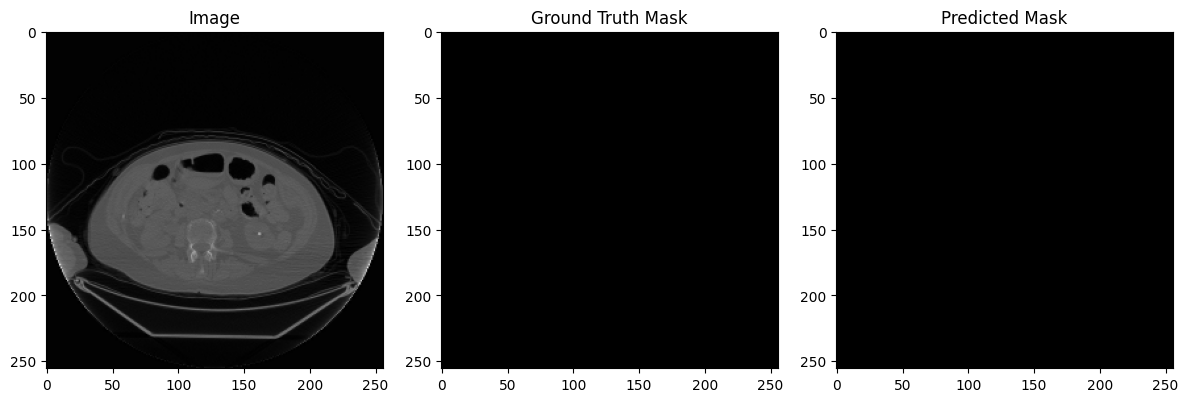

Dice score: 1.0


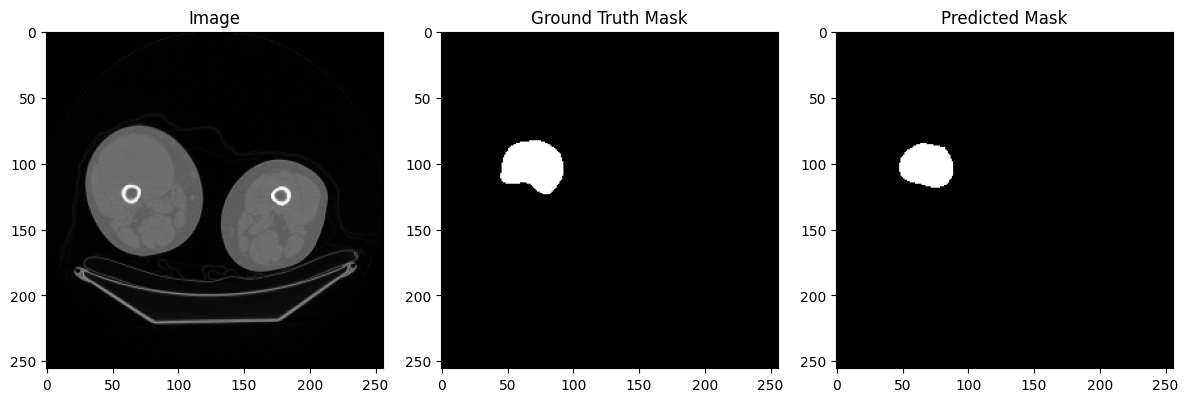

Dice score: 0.8494117643727798


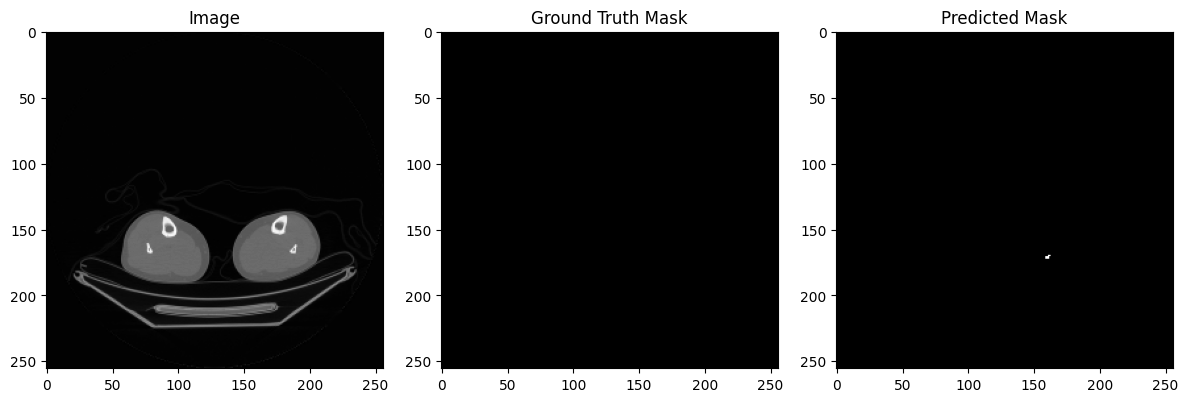

Dice score: 0.0


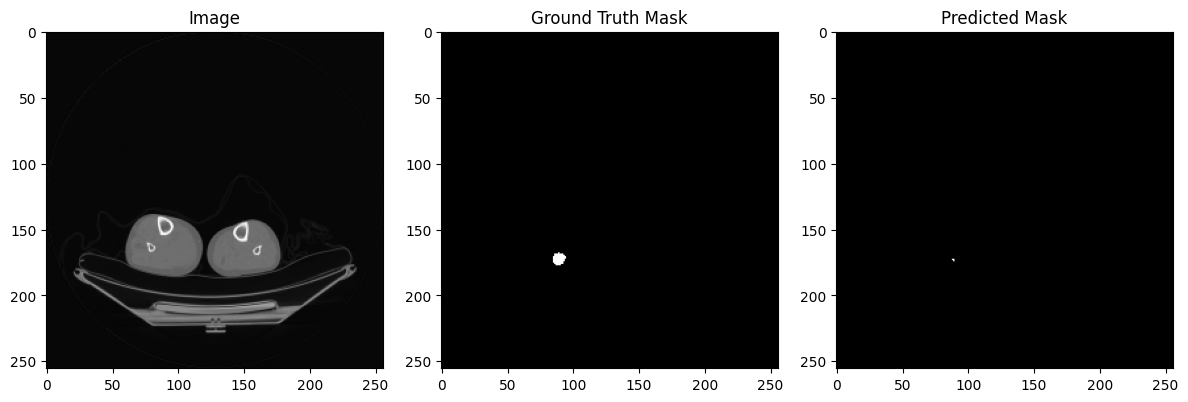

Dice score: 0.07894736738227148


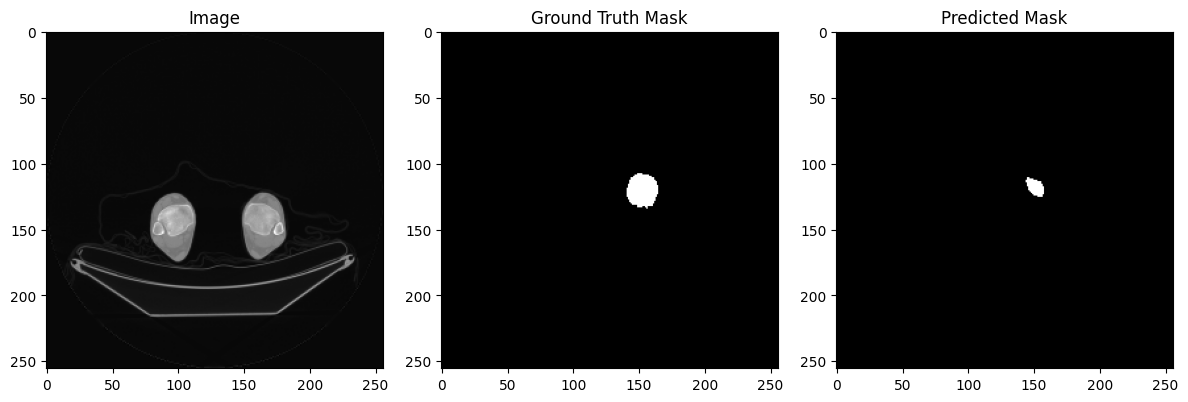

Dice score: 0.4409448811953624


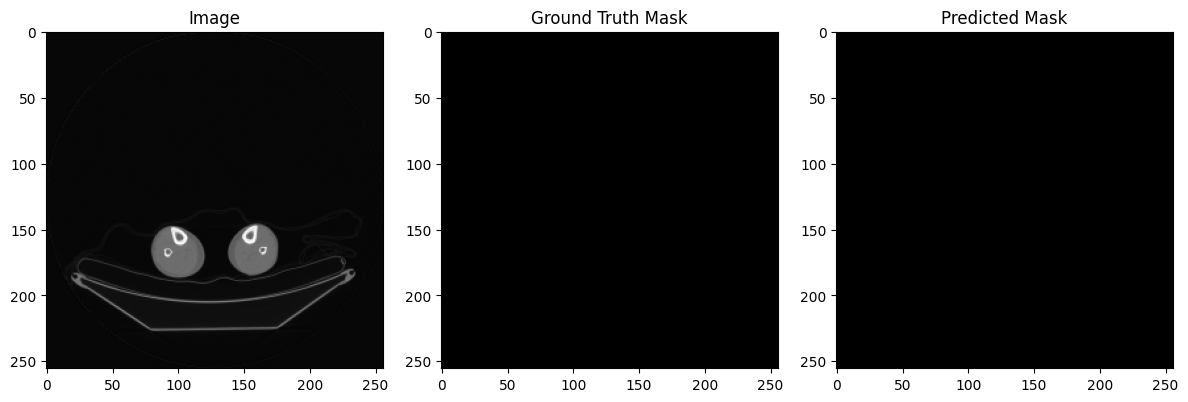

Dice score: 1.0


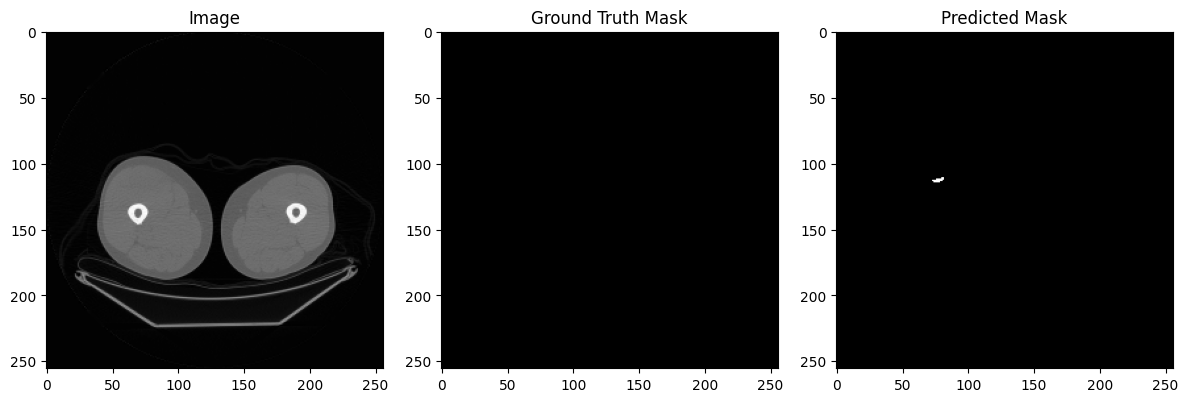

Dice score: 0.0


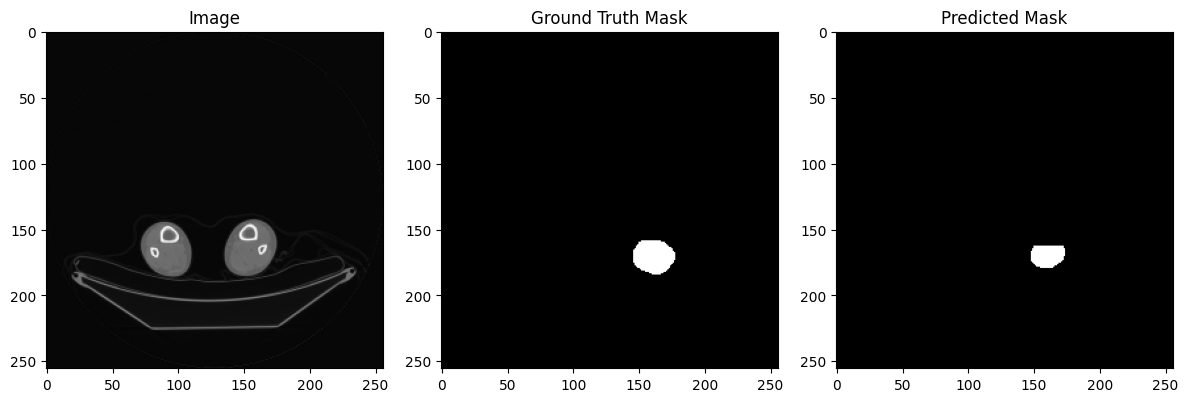

Dice score: 0.7326923069877957


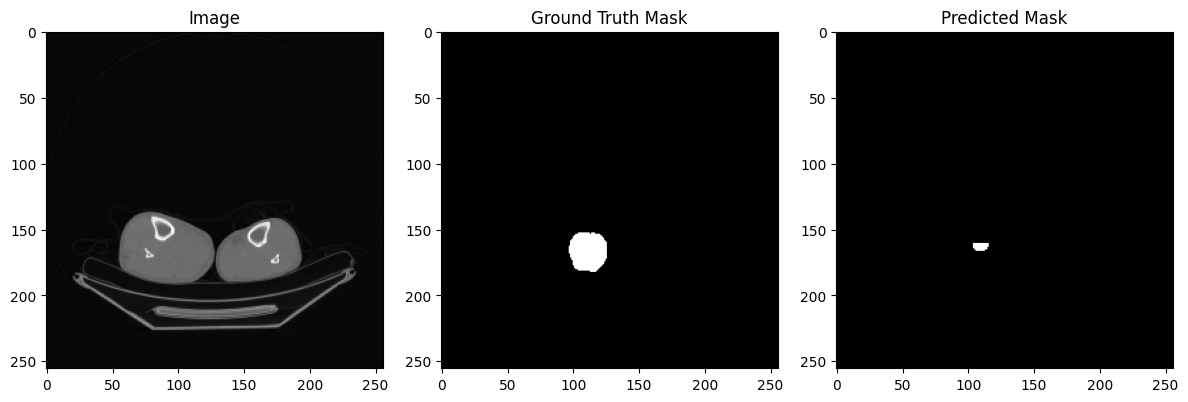

Dice score: 0.163057324633048


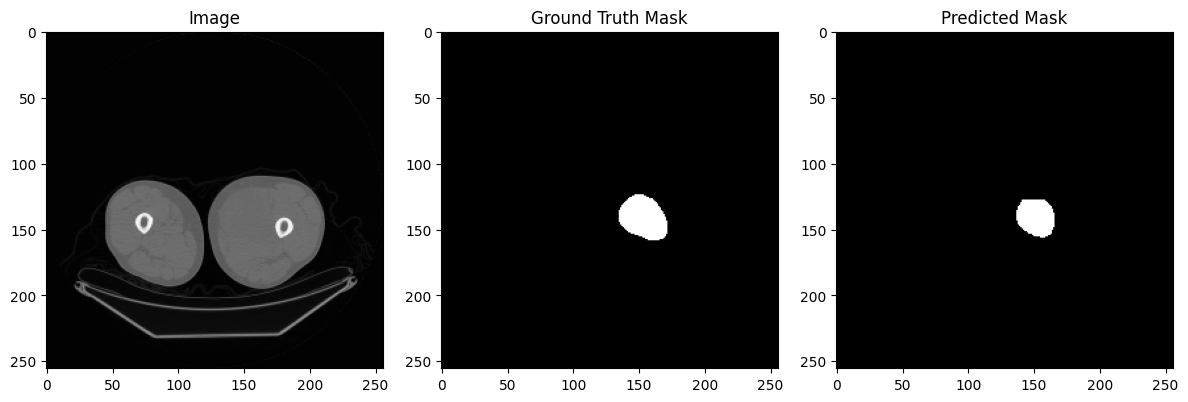

Dice score: 0.8306010923918633


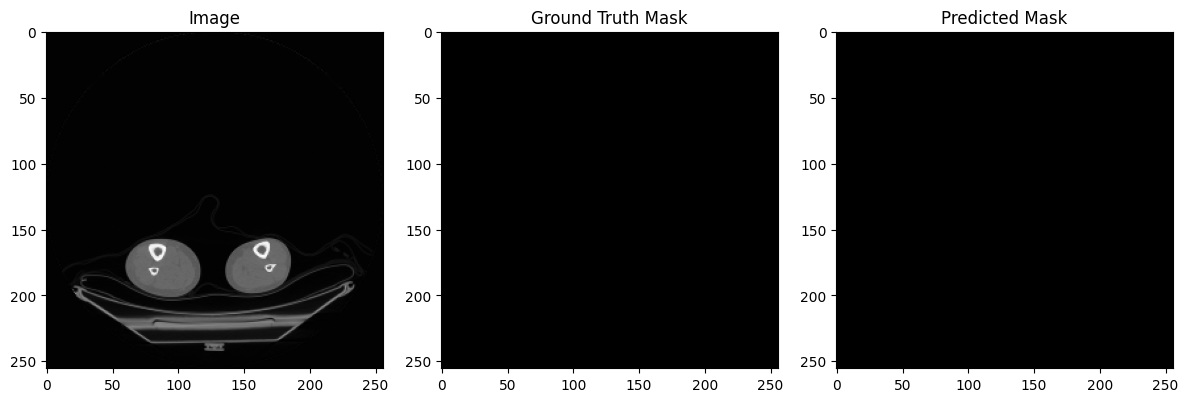

Dice score: 1.0


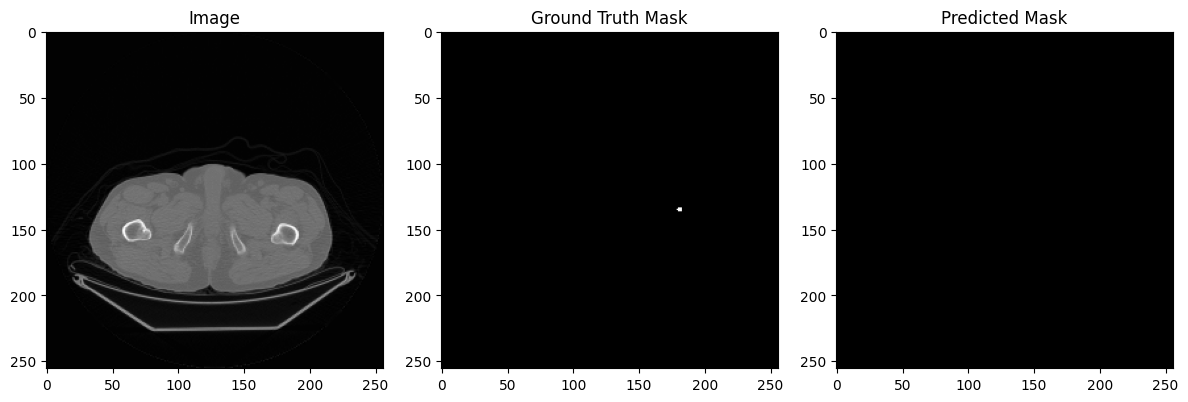

Dice score: 0.0


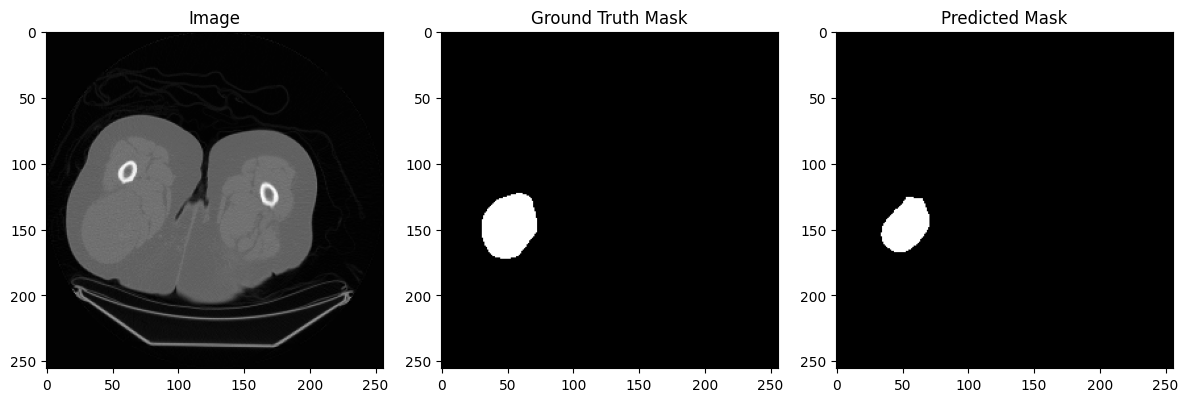

Dice score: 0.8020679465280399


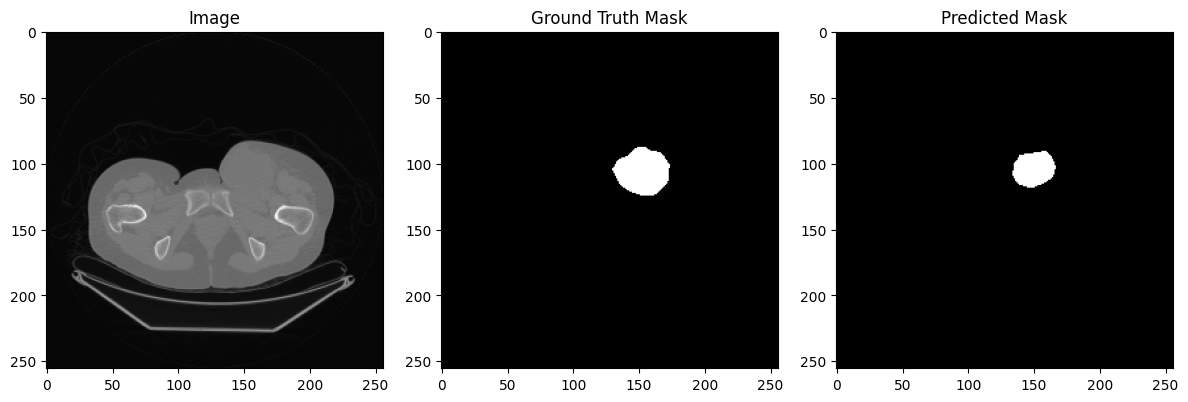

Dice score: 0.7414529910569161


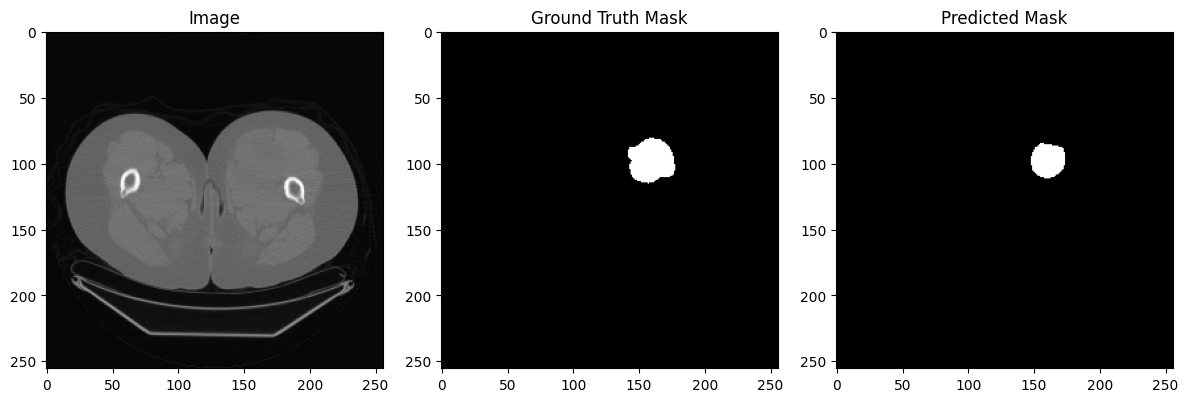

Dice score: 0.7436582104514965


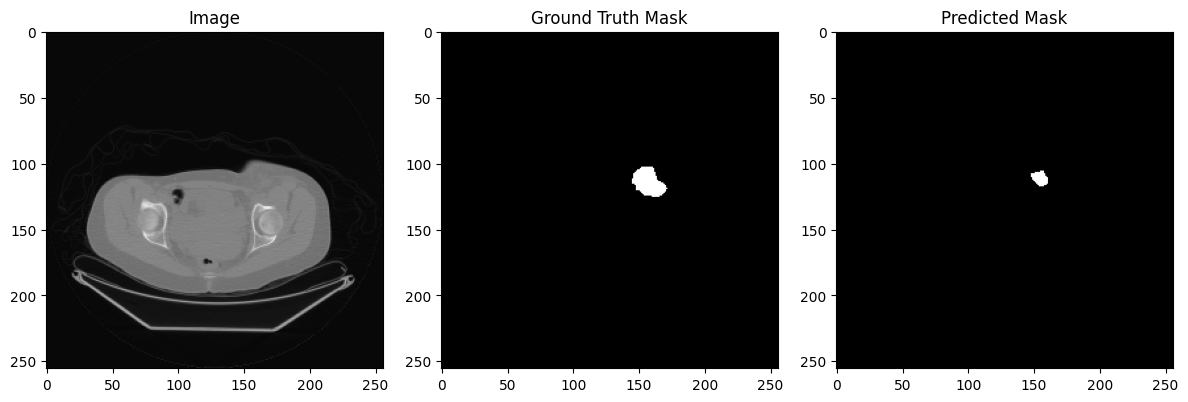

Dice score: 0.42166344212444207


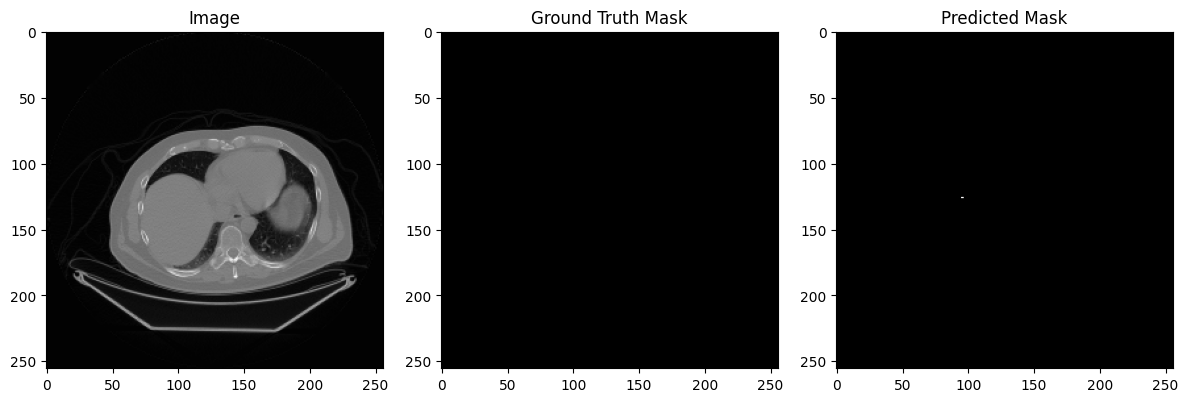

Dice score: 0.0


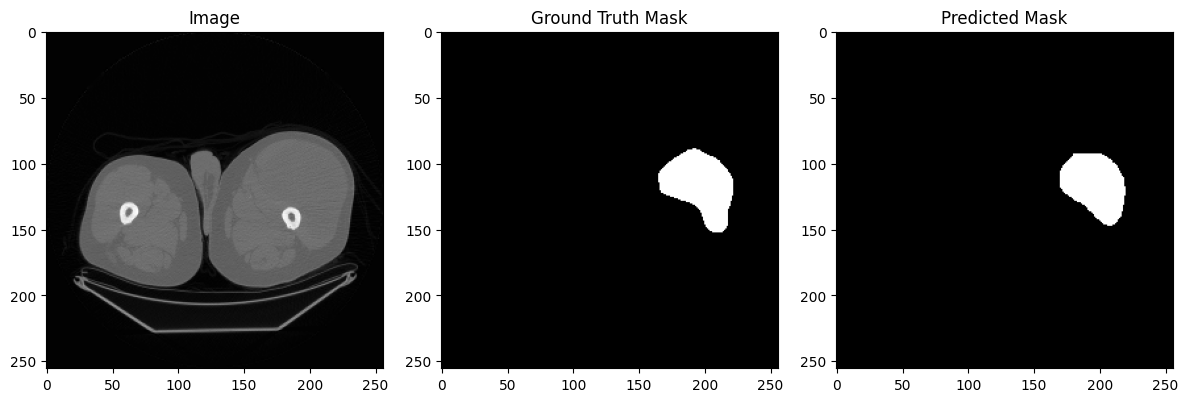

Dice score: 0.9042476599701829


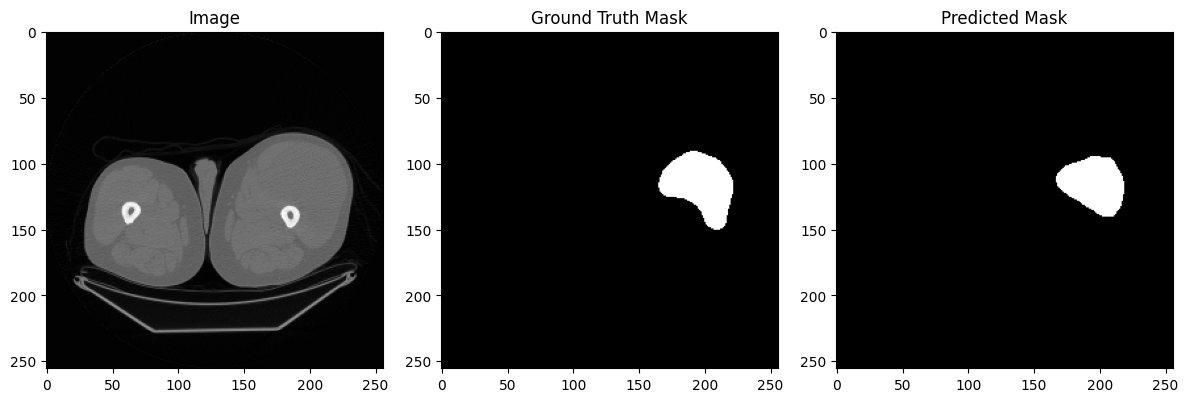

Dice score: 0.8675145731670603


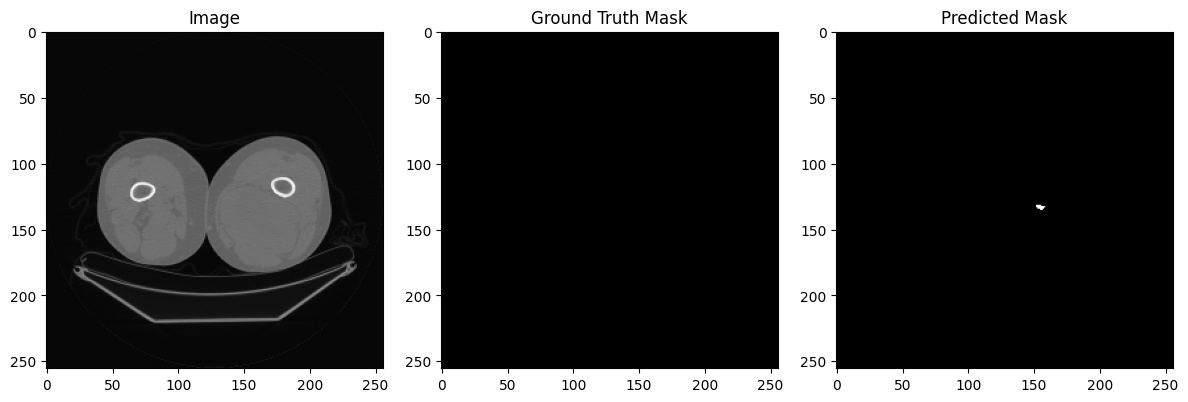

Dice score: 0.0


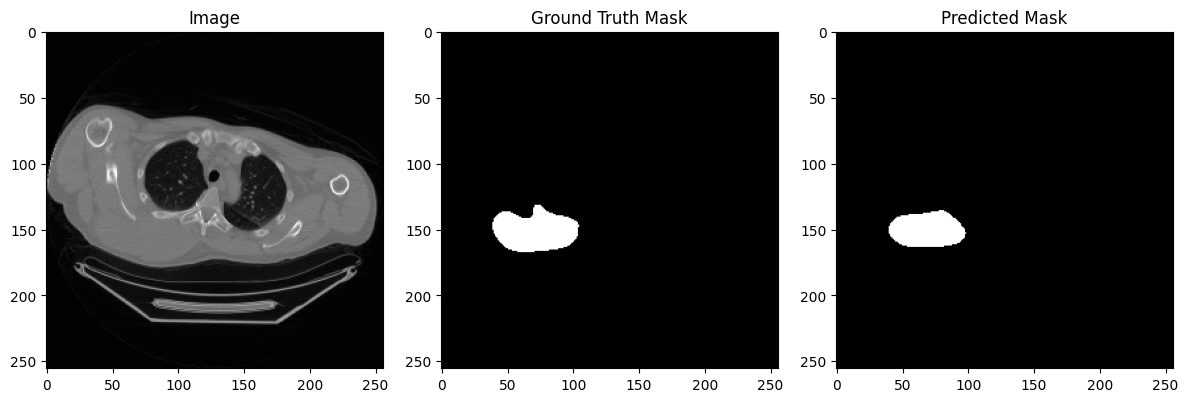

Dice score: 0.8442483879049039


In [20]:
plot_predictions(img_dir, mask_dir, post_predict_dir, 50)